In [5]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn, morris
from scipy.signal import correlate
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
from experiment import unpack_and_dequantize
import numpy as np
import seaborn as sns
from ripser import ripser
from scipy.signal import detrend
import pandas as pd
import pickle
import time
import os
from scipy import signal as sp_signal
from scipy.stats import binned_statistic_2d, gaussian_kde, pearsonr
from scipy.ndimage import gaussian_filter
from collections import Counter
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# One-off simulation comparison CPT vs. no-CPT

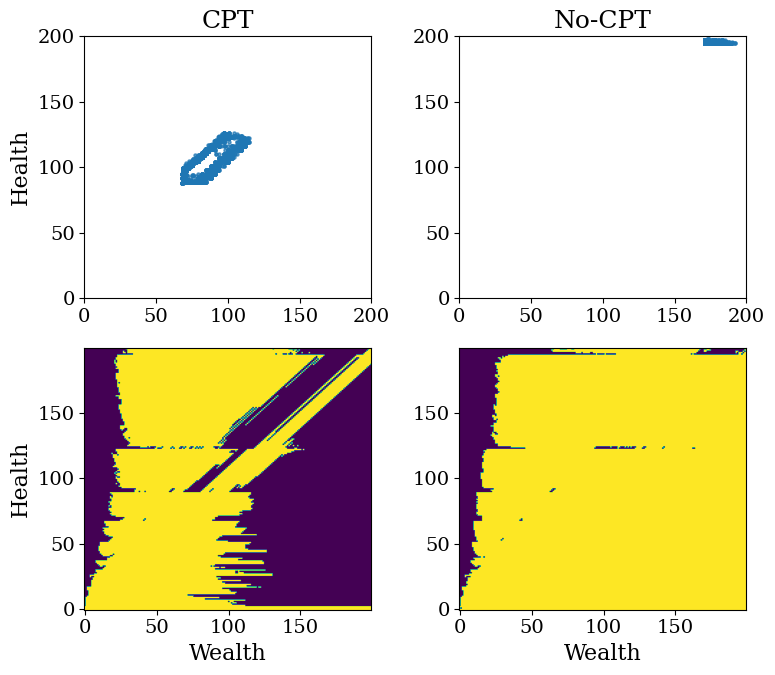

In [3]:
IDX = 547

fig, axs = plt.subplots(2, 2, figsize=(8,7))

cpt_P = None
pt_P = None

for idx, d in enumerate(["cpt/", "pt/"]):
    for i, file in enumerate(sorted(os.listdir(d))):
        if i == IDX:
            with open(d+file, "rb") as f:
                res = pickle.load(f)
            P = res["policy"]
            if d=="cpt/":
                cpt_P = P
                cpt_f = d+file
            else:
                pt_P = P
                pt_f = d+file
            break
    axs[0][idx].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=5,
        alpha=0.7
    )
    axs[0][idx].set_xlim(0,200)
    axs[0][idx].set_ylim(0,200)
    axs[1][idx].imshow(P.T, origin="lower", aspect="auto")

axs[0][0].set_title("CPT")
axs[0][1].set_title("PT")
axs[0][0].set_ylabel("Health")
axs[1][0].set_ylabel("Health")

axs[1][0].set_xlabel("Wealth")
axs[1][1].set_xlabel("Wealth")

fig.tight_layout()
plt.show()

In [4]:
A = res["params"]["w_delta_scale"]
alpha = res["params"]["alpha"]
P_H_decrease = res["params"]["P_H_decrease"]
P_H_increase = res["params"]["P_H_increase"]

w_init = 20
h_init = 20

cpt_agent = (w_init, h_init)
cpt_util = [utility(w_init, h_init, alpha)]
cpt_pos = []

pt_agent = (w_init, h_init)
pt_util = [utility(w_init, h_init, alpha)]
pt_pos = []

num_steps = 5000

for s in tqdm(range(num_steps)):

    RN = np.random.uniform(0,1,1)

    # CPT
    w, h = cpt_agent
    w = int(w)
    h = int(h)
    cpt_decision = cpt_P[w-1, h-1]
    invest_cost = compute_health_cost(h)
    health_delta = compute_health_delta(h)

    if cpt_decision == 1 and w > invest_cost:
        new_w = compute_new_wealth(w-invest_cost, A, utility(w-invest_cost, h, alpha), 200)
        new_h = h
        if RN < P_H_increase:
            new_h = min(h + health_delta, 200)
        cpt_agent = (new_w, new_h)
        cpt_util.append(utility(new_w, new_h, alpha))
        cpt_pos.append(cpt_agent)
    else:
        new_w = compute_new_wealth(w, A, utility(w, h, alpha), 200)
        new_h = h
        if RN < P_H_decrease:
            new_h = max(1, h - health_delta)
        cpt_agent = (int(new_w), int(new_h))
        cpt_util.append(utility(new_w, new_h, alpha))
        cpt_pos.append(cpt_agent)
            
    # PT
    w, h = pt_agent
    w = int(w)
    h = int(h)
    pt_decision = pt_P[w-1, h-1]
    invest_cost = compute_health_cost(h)
    health_delta = compute_health_delta(h)

    if pt_decision == 1 and w > invest_cost:
        new_w = compute_new_wealth(w-invest_cost, A, utility(w-invest_cost, h, alpha), 200)
        new_h = h
        if RN < P_H_increase:
            new_h = min(h + health_delta, 200)
        pt_agent = (new_w, new_h)
        pt_util.append(utility(new_w, new_h, alpha))
        pt_pos.append(pt_agent)
    else:
        new_w = compute_new_wealth(w, A, utility(w, h, alpha), 200)
        new_h = h
        if RN < P_H_decrease:
            new_h = max(1, h - health_delta)
        pt_agent = (int(new_w), int(new_h))
        pt_util.append(utility(new_w, new_h, alpha))
        pt_pos.append(pt_agent)

  0%|          | 0/5000 [00:00<?, ?it/s]

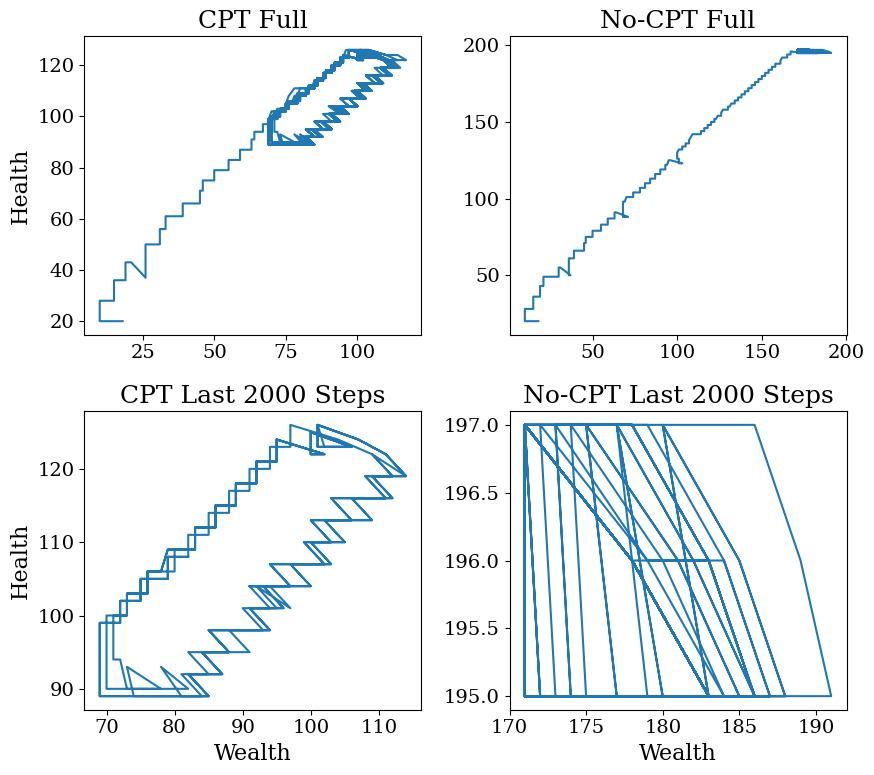

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))

timesteps = [num_steps, 2000]

for j, t in enumerate(timesteps):
    for i, arr in enumerate([cpt_pos, pt_pos]):
        axs[j][i].plot(
            [x[0] for x in arr[-t:]],
            [x[1] for x in arr[-t:]],
        )

axs[0][0].set_ylabel("Health")
axs[1][0].set_ylabel("Health")
axs[1][0].set_xlabel("Wealth")
axs[1][1].set_xlabel("Wealth")

axs[0][0].set_title("CPT Full")
axs[1][0].set_title(f"CPT Last {timesteps[-1]} Steps")
axs[0][1].set_title("PT Full")
axs[1][1].set_title(f"PT Last {timesteps[-1]} Steps")

fig.tight_layout()
plt.show()

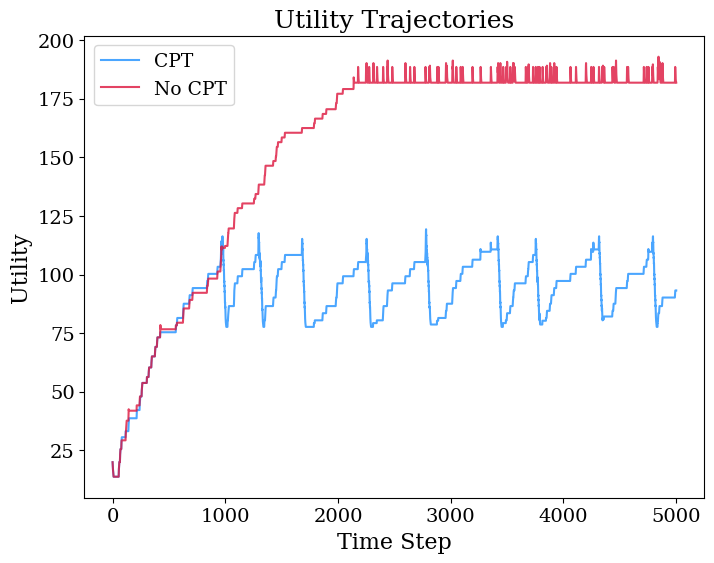

In [6]:
plt.plot(cpt_util, alpha=0.8, label="CPT", color="dodgerblue")
plt.plot(pt_util, alpha=0.8, label="PT", color="crimson")
plt.legend()

plt.title("Utility Trajectories")
plt.xlabel("Time Step")
plt.ylabel("Utility")
plt.show()

# Sliding Experiment

In [8]:
def compute_freqs(res, discard_steps=3000, power_threshold_ratio=0.20, trivial_range_threshold=0.0):
    w = res["wealth"][:, discard_steps:].astype(np.int16)
    h = res["health"][:, discard_steps:].astype(np.int16)
    u = utility(w, h, res["params"]["alpha"])

    # Threshold based on utility range during steady state
    u_last = u[:, -500:]
    u_range = np.max(u_last, axis=1) - np.min(u_last, axis=1)
    is_trivial = u_range < trivial_range_threshold

    dominant_frequencies = np.full(w.shape[0], np.nan)
    dominant_amplitudes = np.full(w.shape[0], np.nan)
    is_significant = ~is_trivial
    if not np.any(is_significant):
        return dominant_frequencies, dominant_amplitudes

    # Prepare and detrend signals
    u_to_process = u[is_significant]
    u = detrend(u_to_process, axis=1)

    # Apply Hann window
    N = u.shape[1]
    window = np.hanning(N)
    u_windowed = u * window

    # FFT with proper normalization (divide by N and window RMS correction)
    window_rms = np.sqrt(np.mean(window ** 2))
    fft_vals_complex = np.fft.fft(u_windowed, axis=1) / (N * window_rms)
    fft_freqs = np.fft.fftfreq(N, 1)

    # Positive frequencies only
    pos_mask = fft_freqs > 0
    fft_freqs_pos = fft_freqs[pos_mask]

    # Power spectral density
    psd = np.abs(fft_vals_complex[:, pos_mask])**2

    # Denoise by thresholding
    peak_power_per_agent = np.max(psd, axis=1, keepdims=True)
    peak_power_per_agent[peak_power_per_agent == 0] = 1
    power_threshold = power_threshold_ratio * peak_power_per_agent
    psd[psd < power_threshold] = 0

    # Find dominant frequency and corresponding amplitude
    dominant_idx = np.argmax(psd, axis=1)
    dominant_freq_vals = fft_freqs_pos[dominant_idx]
    dominant_power_vals = psd[np.arange(psd.shape[0]), dominant_idx]

    # Handle zero-power cases
    zero_power_mask = np.max(psd, axis=1) == 0
    dominant_freq_vals[zero_power_mask] = np.nan
    dominant_power_vals[zero_power_mask] = np.nan

    # Store results
    dominant_frequencies[is_significant] = dominant_freq_vals
    dominant_amplitudes[is_significant] = 2 * np.sqrt(dominant_power_vals)

    return dominant_frequencies, dominant_amplitudes

### $\gamma$

In [9]:
D = "slide_gamma/"
IDX = 3

In [10]:
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX]))
freq = []
amp = []
for idx, file in tqdm(enumerate(ordered_files)):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    freqs, amps = compute_freqs(res)
    freq.append(np.mean(freqs[~np.isnan(freqs)]))
    amp.append(np.mean(amps[~np.isnan(freqs)]))

0it [00:00, ?it/s]

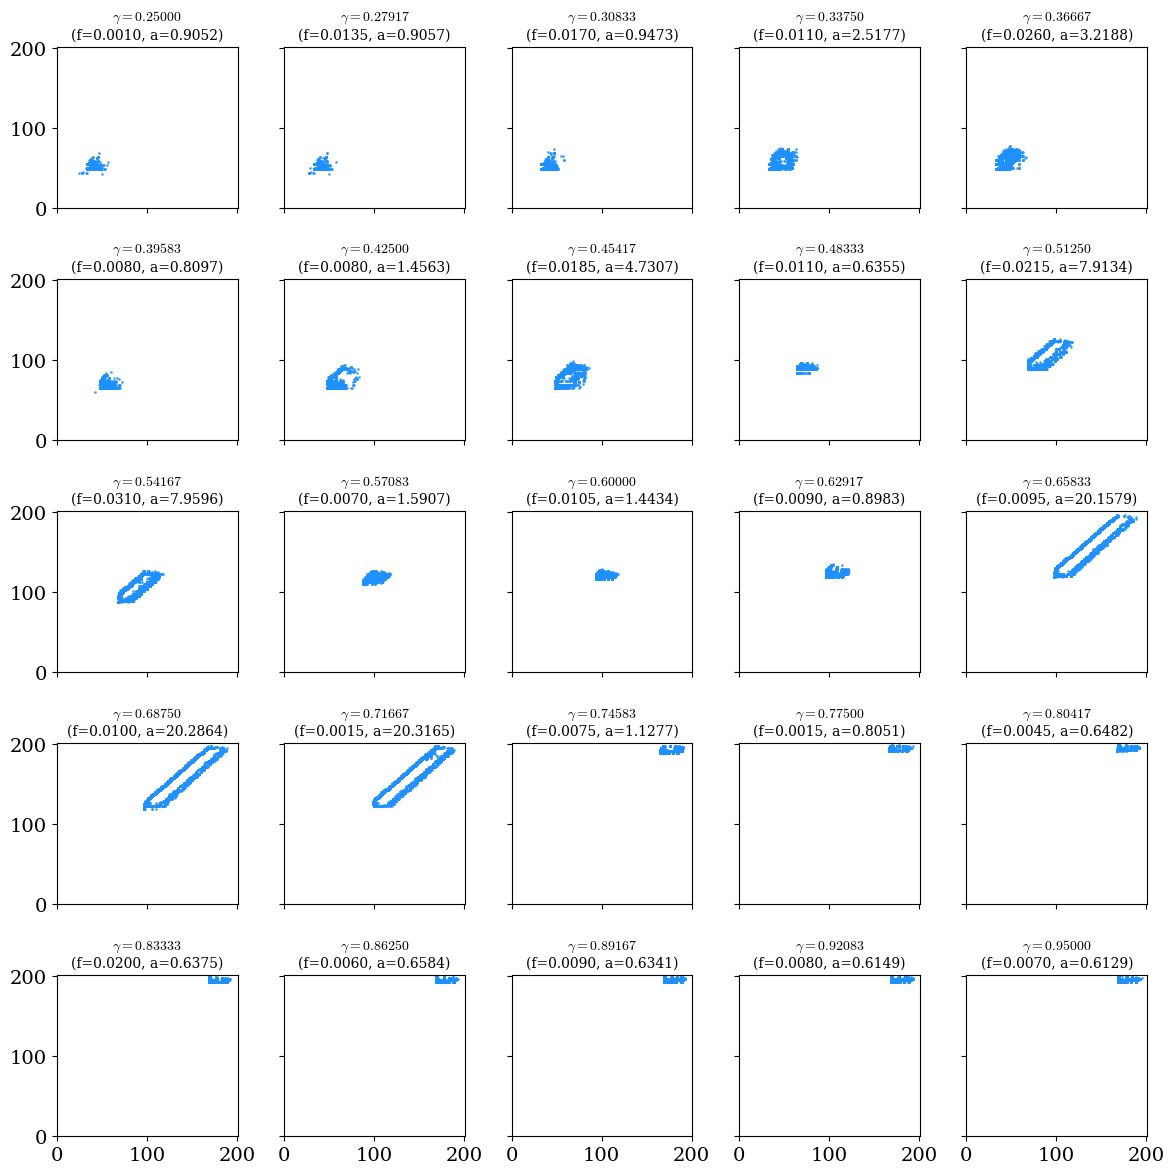

In [20]:
fig, axs = plt.subplots(5, 5, figsize=(12,12), sharex=True, sharey=True)

for idx, file in enumerate(ordered_files):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    gamma = float(file.split("_")[IDX])
    axs[int(idx/5)][idx%5].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=1,
        alpha=0.7,
        color="dodgerblue"
    )
    axs[int(idx/5)][idx%5].set_xlim(0,201)
    axs[int(idx/5)][idx%5].set_ylim(0,201)
    axs[int(idx/5)][idx%5].set_title(fr"$\gamma={gamma:.5f}$" +"\n"+ fr"(f={freqs[idx]:.4f}, a={amp[idx]:.4f})", fontsize=12)

fig.tight_layout()
plt.show()

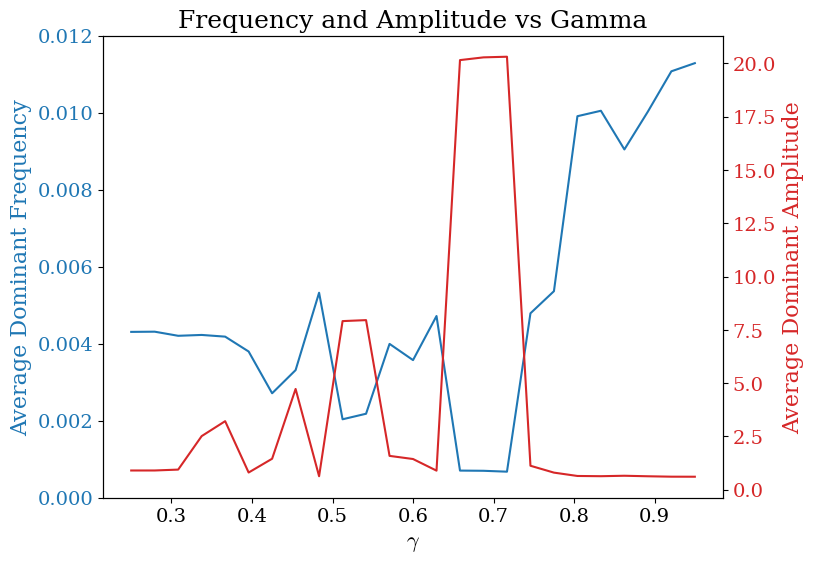

In [21]:
gamma = np.linspace(0.25, 0.95, 25)

fig, ax1 = plt.subplots()

# Primary axis (freq)
ax1.plot(gamma, freq, color='tab:blue')
ax1.set_xlabel(r"$\gamma$")
ax1.set_ylabel("Average Dominant Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 0.012)

# Secondary axis (amp)
ax2 = ax1.twinx()
ax2.plot(gamma, amp, color='tab:red')
ax2.set_ylabel("Average Dominant Amplitude", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Frequency and Amplitude vs Gamma")
plt.show()

### $\omega$

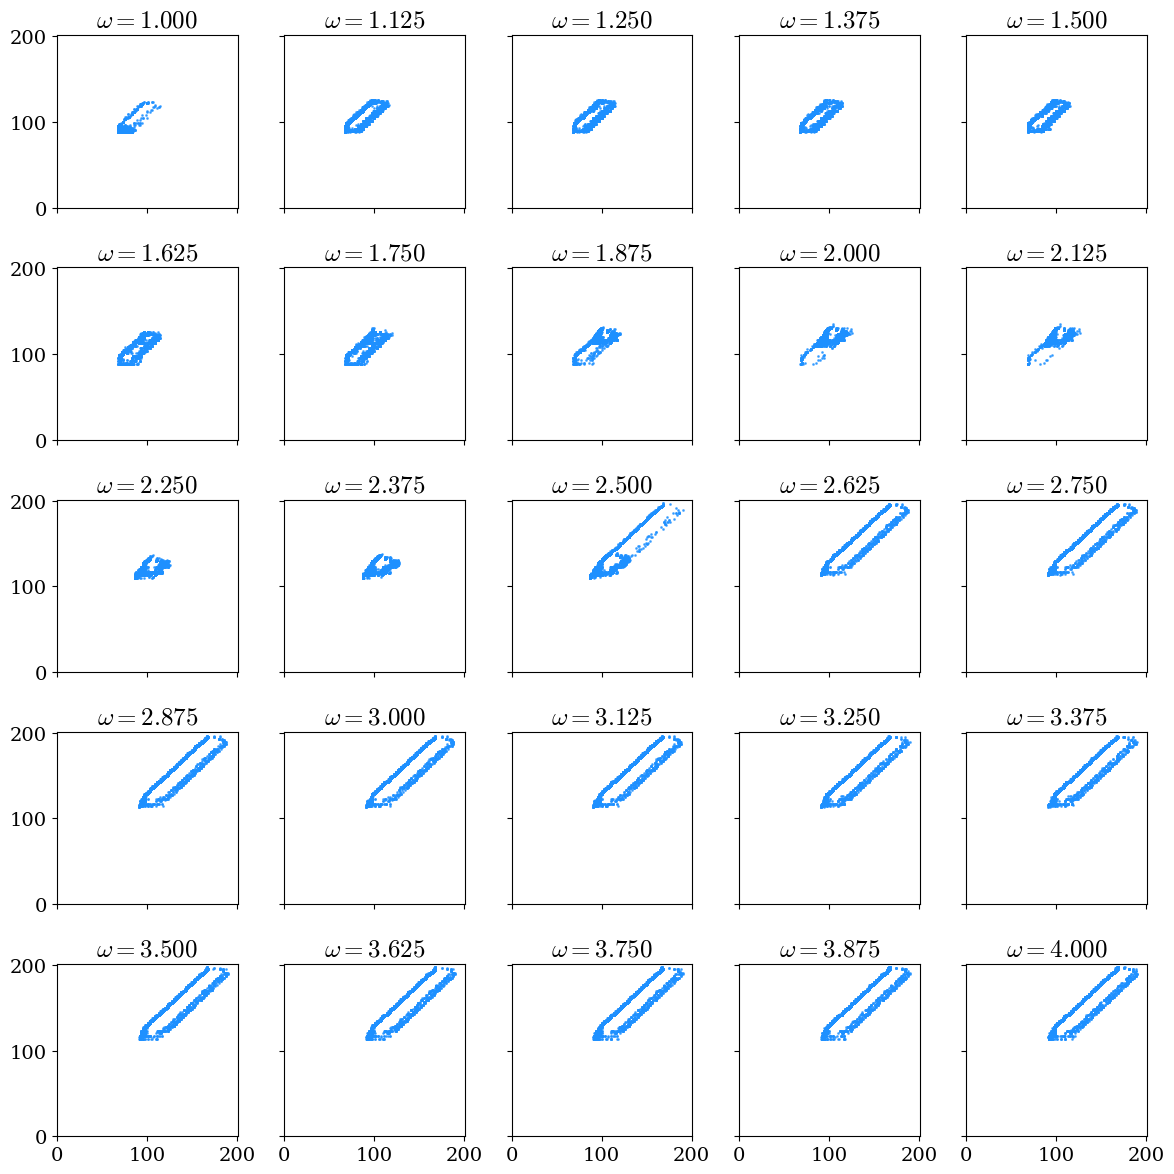

In [169]:
D = "slide_omega/"
IDX = 5
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX]))

fig, axs = plt.subplots(5, 5, figsize=(12,12), sharex=True, sharey=True)

for idx, file in enumerate(ordered_files):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    omega = float(file.split("_")[IDX])
    axs[int(idx/5)][idx%5].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=1,
        alpha=0.7,
        color="dodgerblue"
    )
    axs[int(idx/5)][idx%5].set_xlim(0,201)
    axs[int(idx/5)][idx%5].set_ylim(0,201)
    axs[int(idx/5)][idx%5].set_title(fr"$\omega={omega:.3f}$")

fig.tight_layout()
plt.show()

In [170]:
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX]))
freq = []
amp = []
for idx, file in tqdm(enumerate(ordered_files)):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    freqs, amps = compute_freqs(res)
    freq.append(np.mean(freqs[~np.isnan(freqs)]))
    amp.append(np.mean(amps[~np.isnan(freqs)]))

0it [00:00, ?it/s]

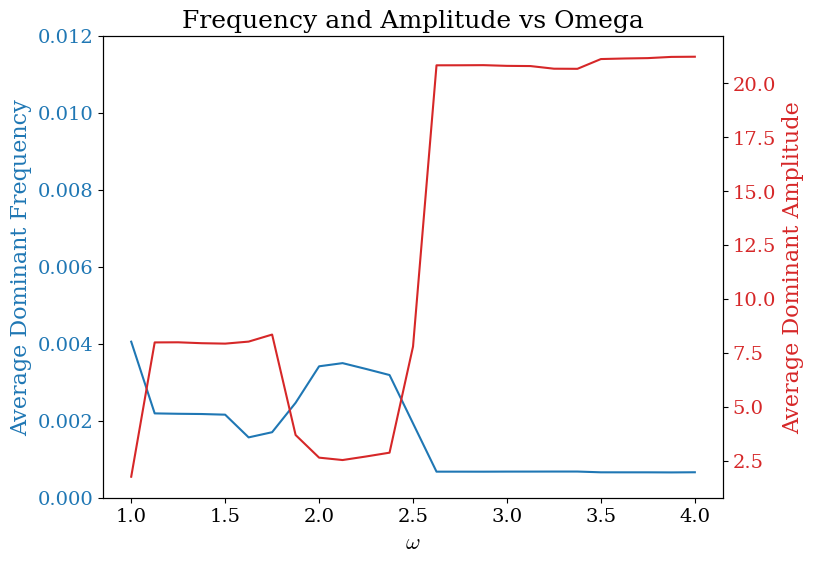

In [171]:
omega = np.linspace(1, 4, 25)

fig, ax1 = plt.subplots()

# Primary axis (freq)
ax1.plot(omega, freq, color='tab:blue')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel("Average Dominant Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 0.012)

# Secondary axis (amp)
ax2 = ax1.twinx()
ax2.plot(omega, amp, color='tab:red')
ax2.set_ylabel("Average Dominant Amplitude", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Frequency and Amplitude vs Omega")
plt.show()

### $\eta$

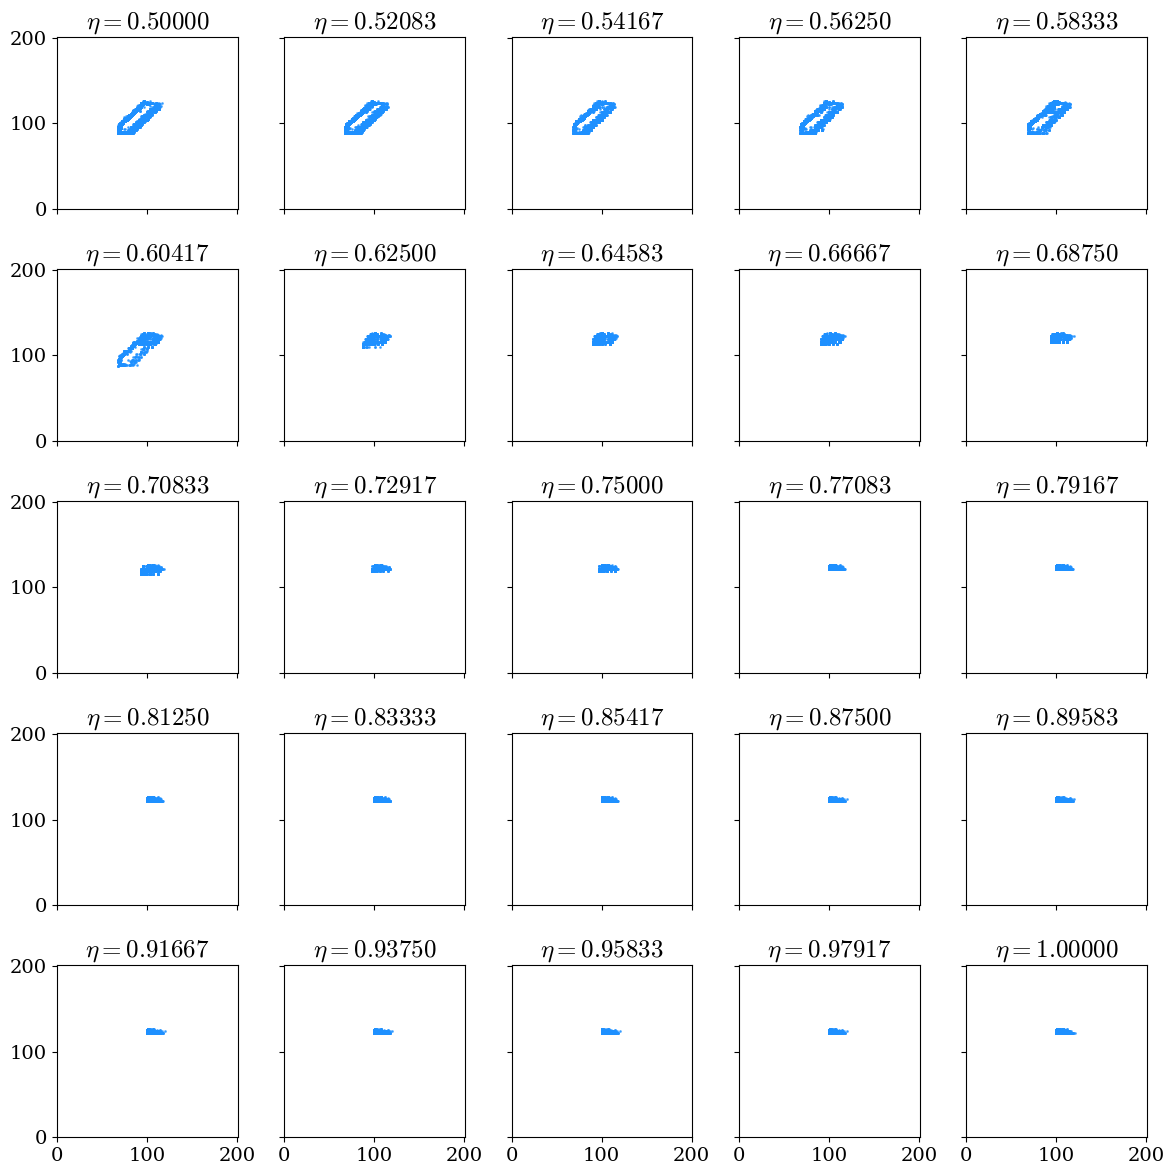

In [172]:
D = "slide_eta/"
IDX = 6
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX].replace(".pickle", "")))
fig, axs = plt.subplots(5, 5, figsize=(12,12), sharex=True, sharey=True)

for idx, file in enumerate(ordered_files):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    eta = float(file.split("_")[IDX].replace(".pickle", ""))
    axs[int(idx/5)][idx%5].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=1,
        alpha=0.7,
        color="dodgerblue"
    )
    axs[int(idx/5)][idx%5].set_xlim(0,201)
    axs[int(idx/5)][idx%5].set_ylim(0,201)
    axs[int(idx/5)][idx%5].set_title(fr"$\eta={eta:.5f}$")

fig.tight_layout()
plt.show()

In [164]:
ordered_files = sorted(os.listdir(D), key=lambda x: float(x.split("_")[IDX].replace(".pickle", "")))
freq = []
amp = []
for idx, file in tqdm(enumerate(ordered_files)):
    with open(D+file, "rb") as f:
        res = pickle.load(f)
    freqs, amps = compute_freqs(res)
    freq.append(np.mean(freqs[~np.isnan(freqs)]))
    amp.append(np.mean(amps[~np.isnan(freqs)]))

0it [00:00, ?it/s]

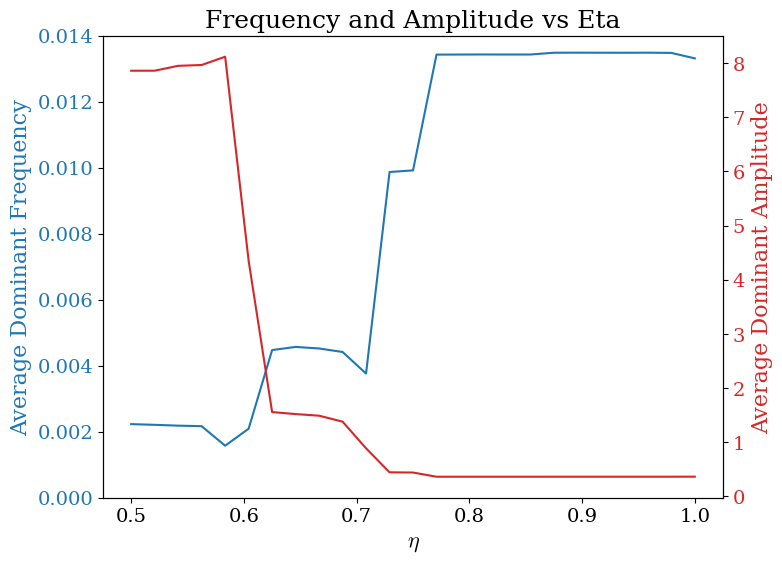

In [167]:
eta = np.linspace(0.5, 1, 25)

fig, ax1 = plt.subplots()

# Primary axis (freq)
ax1.plot(eta, freq, color='tab:blue')
ax1.set_xlabel(r"$\eta$")
ax1.set_ylabel("Average Dominant Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 0.014)

# Secondary axis (amp)
ax2 = ax1.twinx()
ax2.plot(eta, amp, color='tab:red')
ax2.set_ylabel("Average Dominant Amplitude", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Frequency and Amplitude vs Eta")
plt.show()

# Comparing Number of Oscillating Simulations (CPT vs. PT)

In [12]:
with open("cpt_dominant_frequencies_amplitudes.pickle", 'rb') as f:
    cpt = pickle.load(f)
with open("pt_dominant_frequencies_amplitudes.pickle", 'rb') as f:
    pt = pickle.load(f)

In [64]:
cpt_counts = []
pt_counts = []

x = np.linspace(2, 32, 80)

for threshold in tqdm(x):
    cpt_osc = []
    pt_osc = []
    for row in cpt:
        amplitudes = row["amplitudes"]
        if np.mean(amplitudes) > threshold:
            cpt_osc.append(row)

    for row in pt:
        amplitudes = row["amplitudes"]
        if np.mean(amplitudes) > threshold:
            pt_osc.append(row)

    cpt_counts.append(len(cpt_osc)/1024)
    pt_counts.append(len(pt_osc)/1024)

  0%|          | 0/80 [00:00<?, ?it/s]

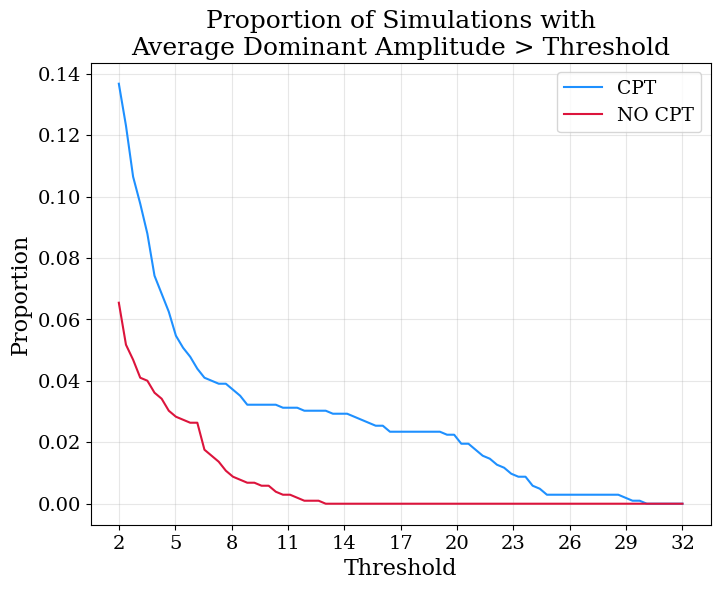

In [65]:
plt.plot(
    x,
    cpt_counts,
    color="dodgerblue",
    label="CPT"
)

plt.plot(
    x,
    pt_counts,
    color="crimson",
    label="PT"
)

plt.legend()
plt.xticks(np.linspace(2, 32, 11))
plt.title("Proportion of Simulations with\nAverage Dominant Amplitude > Threshold")
plt.xlabel("Threshold")
plt.ylabel("Proportion")
plt.grid()
plt.show()

# CPT Cycle Locations and Dependence on Health Cost/Delta

In [7]:
with open("cpt_dominant_frequencies_amplitudes.pickle", 'rb') as f:
    cpt = pickle.load(f)

In [262]:
threshold = 13
d = "cpt/"

count = 0

files = os.listdir(d)

for idx,row in enumerate(cpt):
    amplitudes = row["amplitudes"]
    if np.mean(amplitudes) > threshold:
        count += 1
        with open(d+files[idx], "rb") as f:
            res = pickle.load(f)
        w = res["wealth"]
        h = res["health"]
        if count == 1:
            break

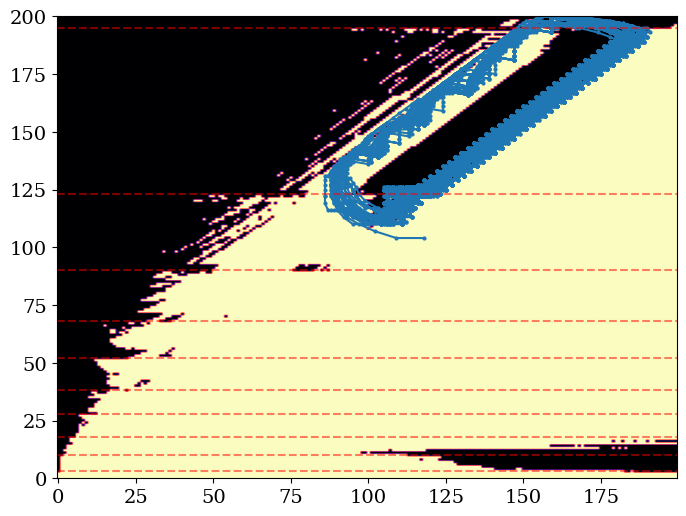

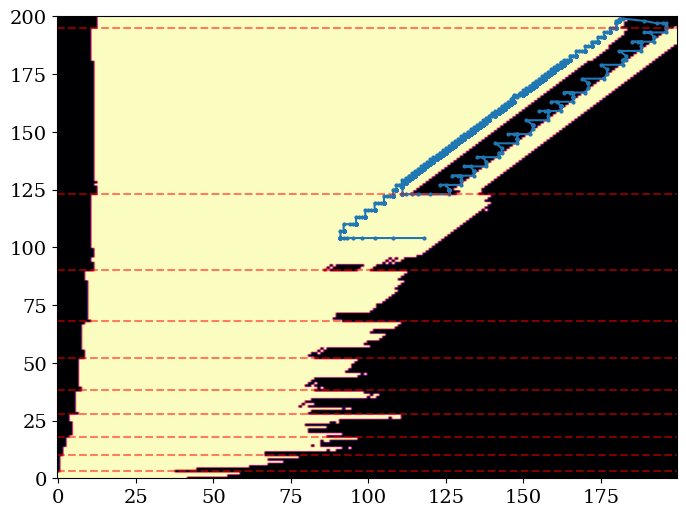

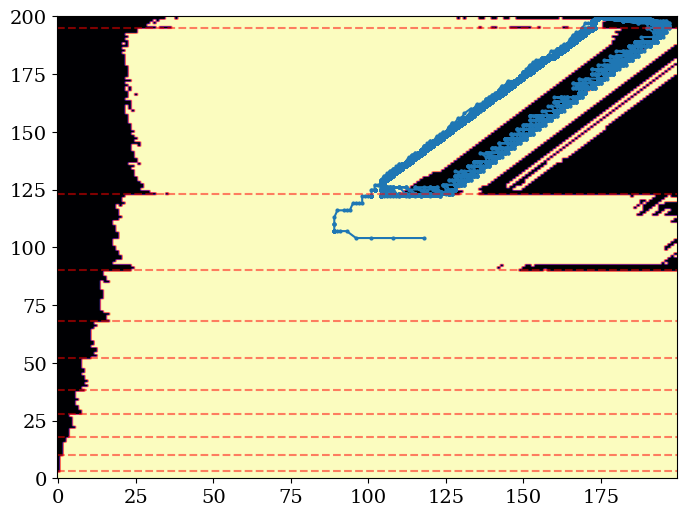

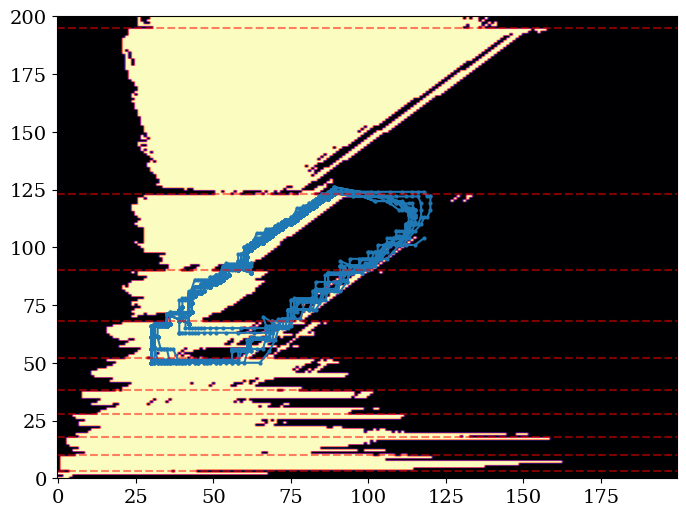

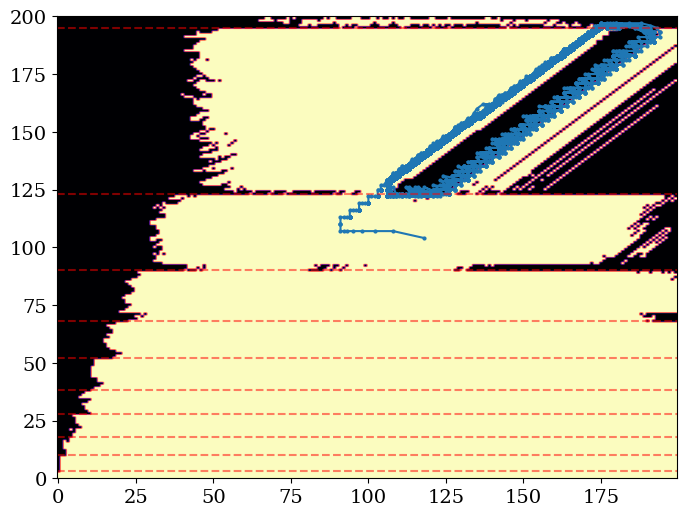

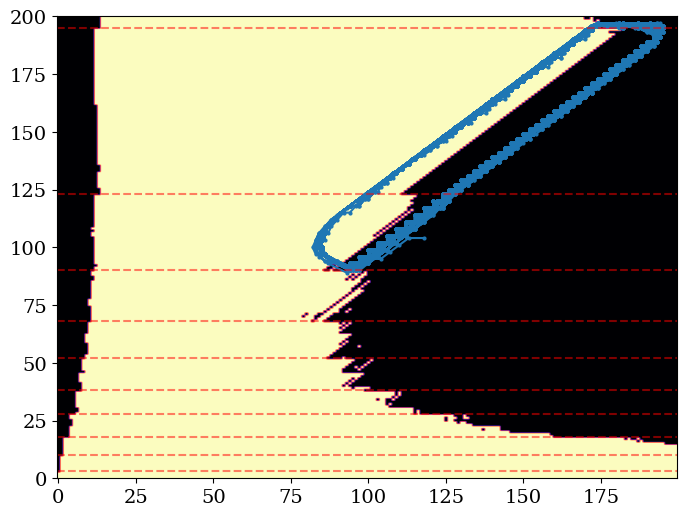

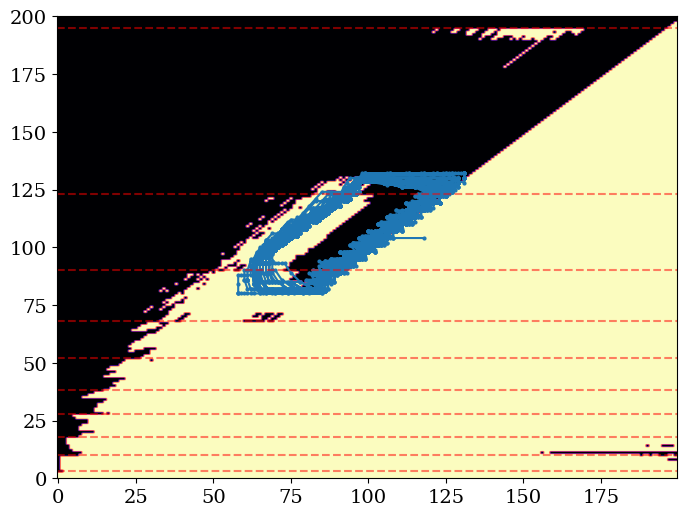

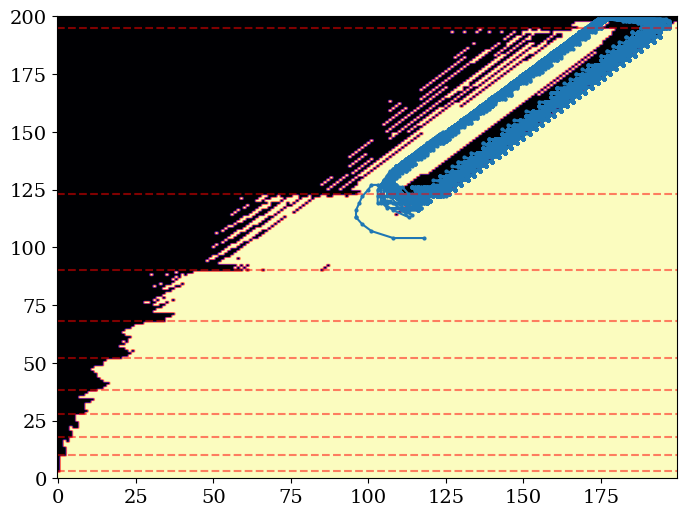

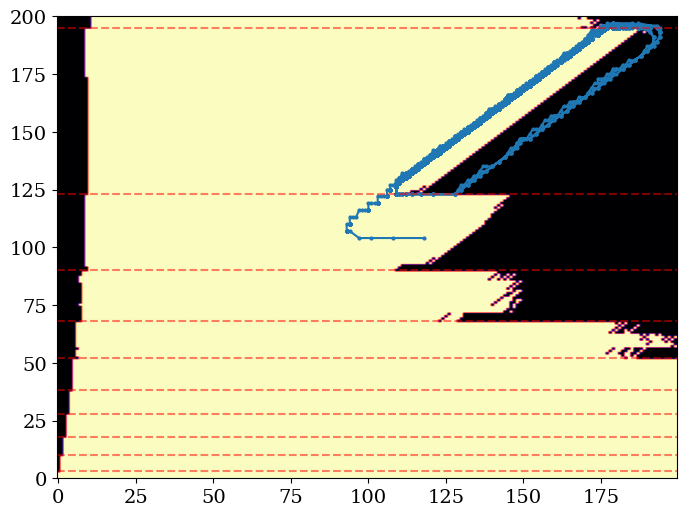

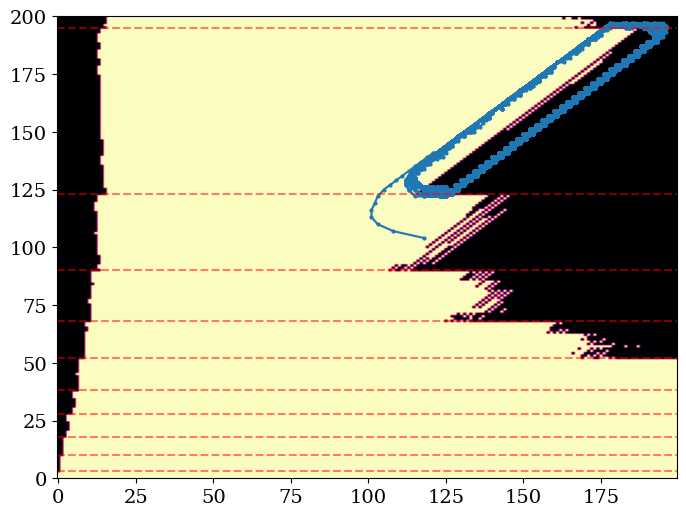

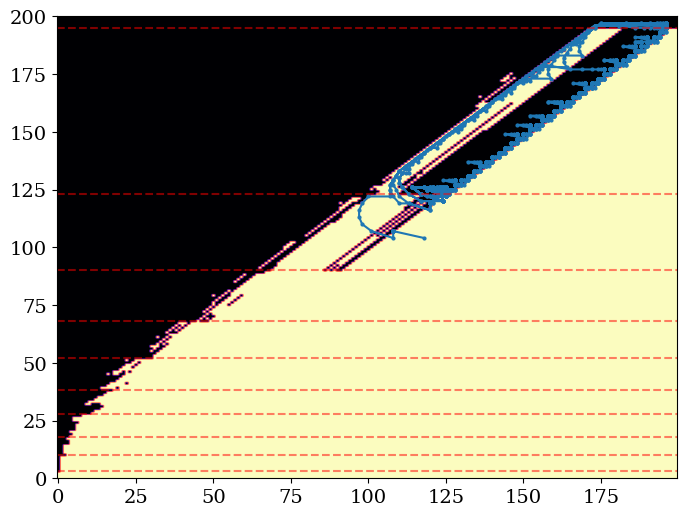

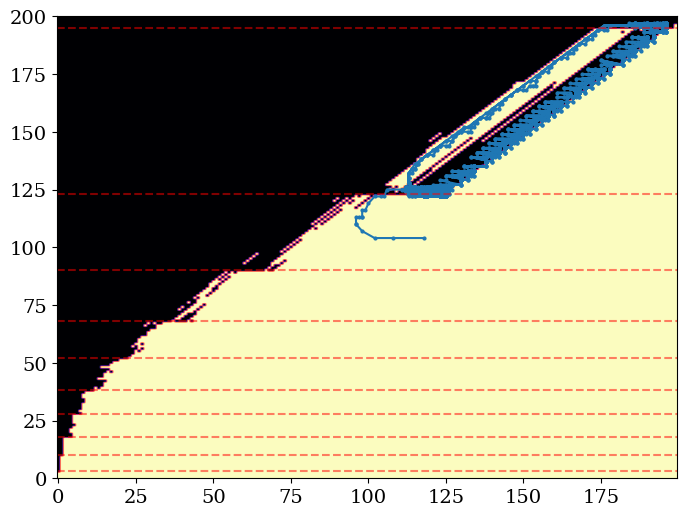

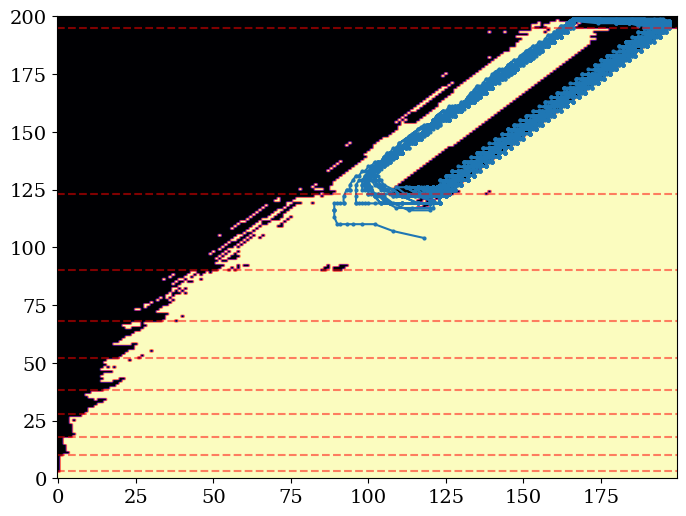

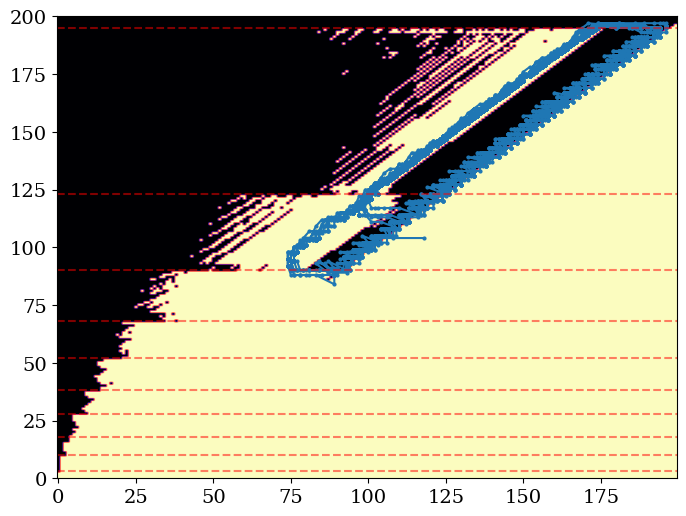

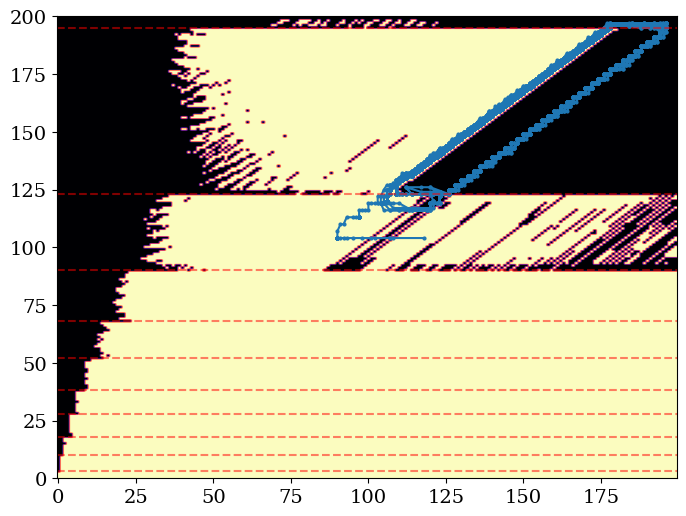

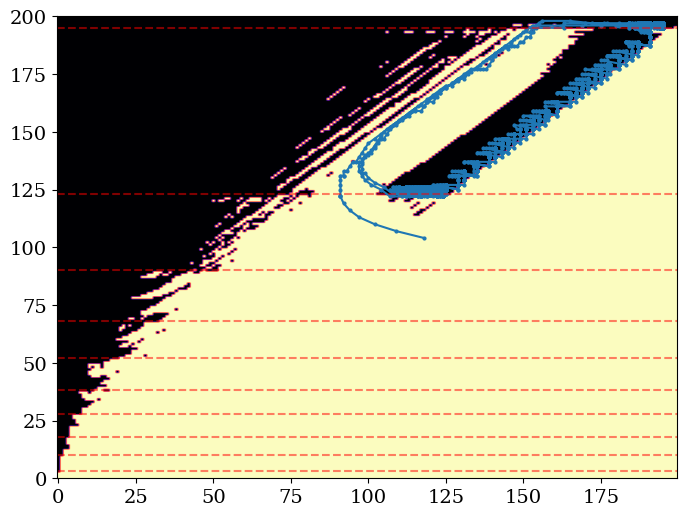

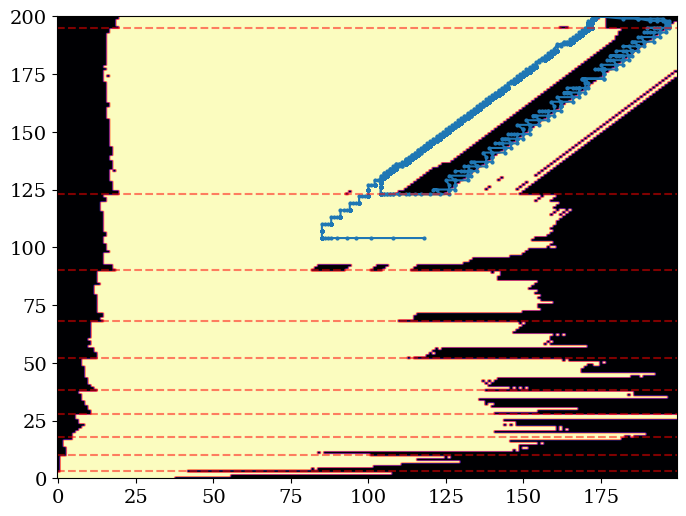

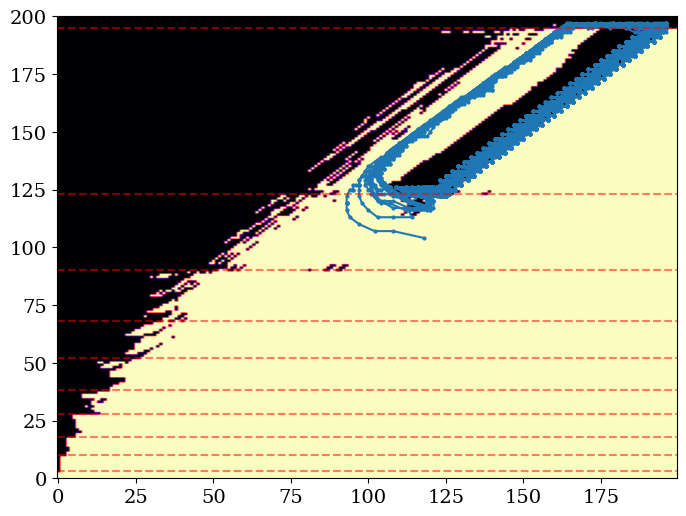

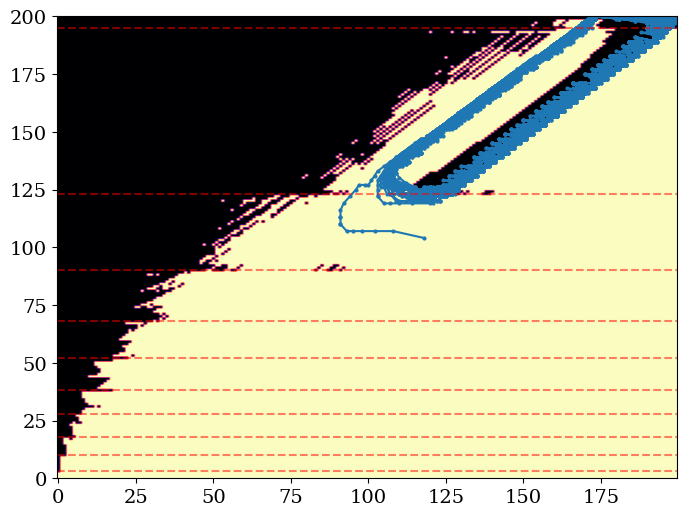

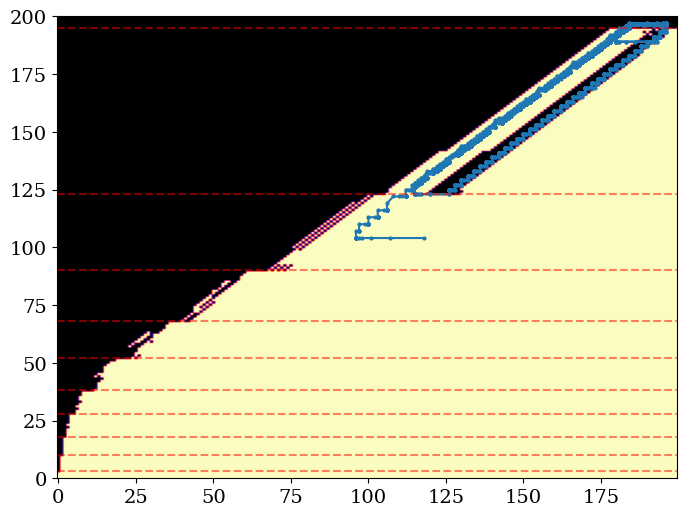

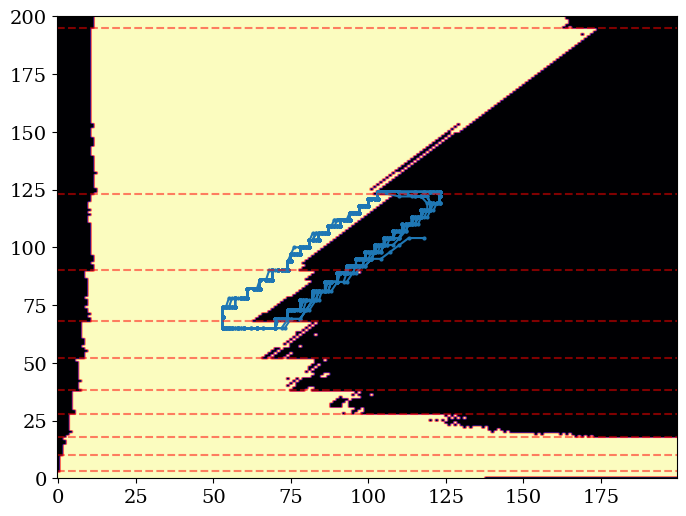

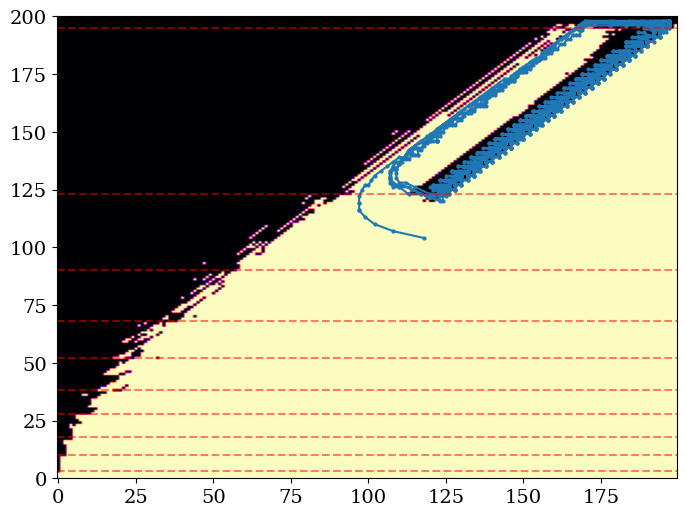

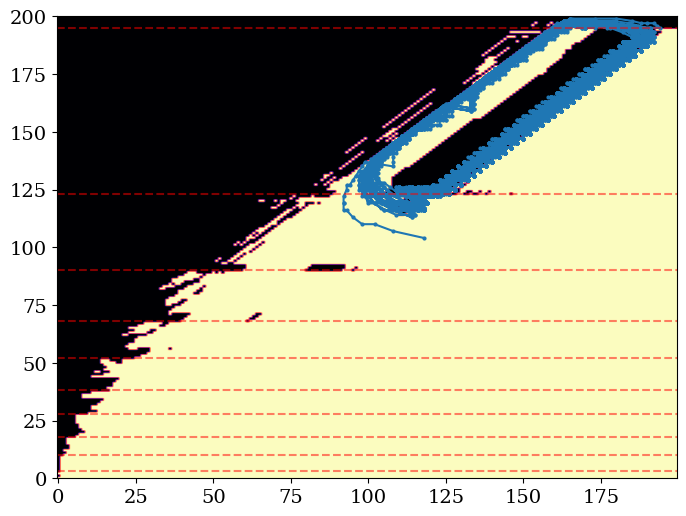

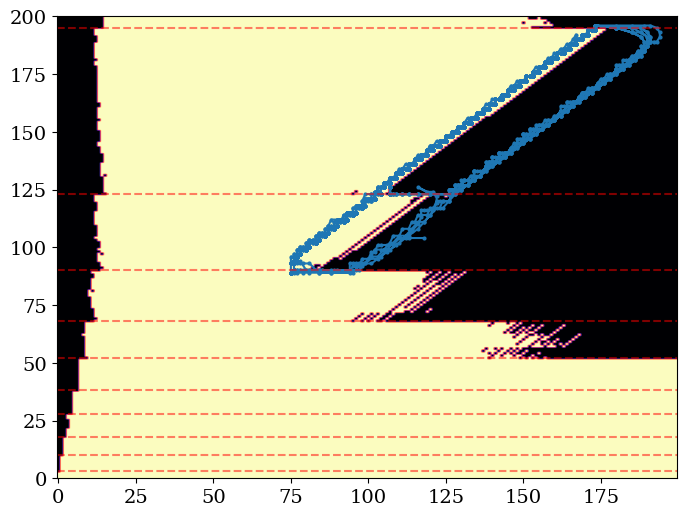

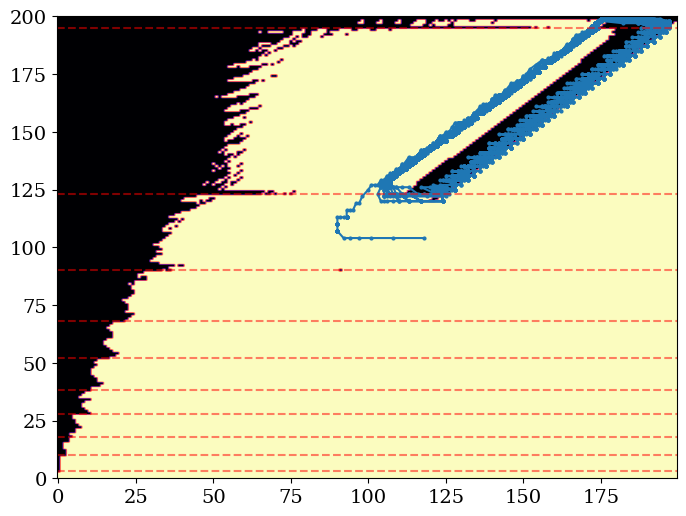

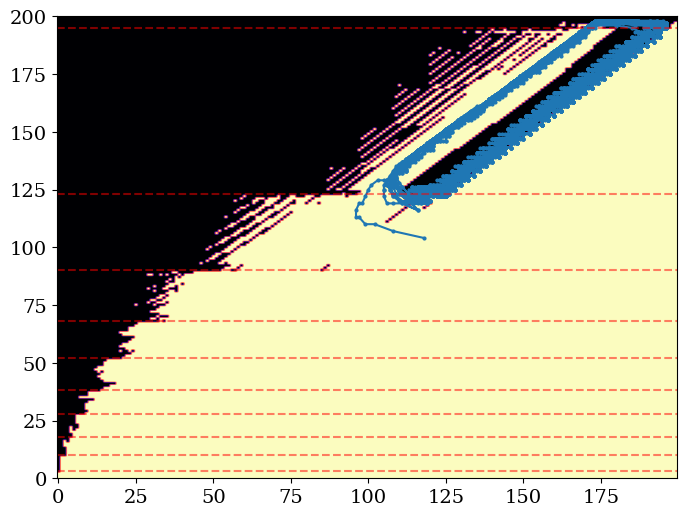

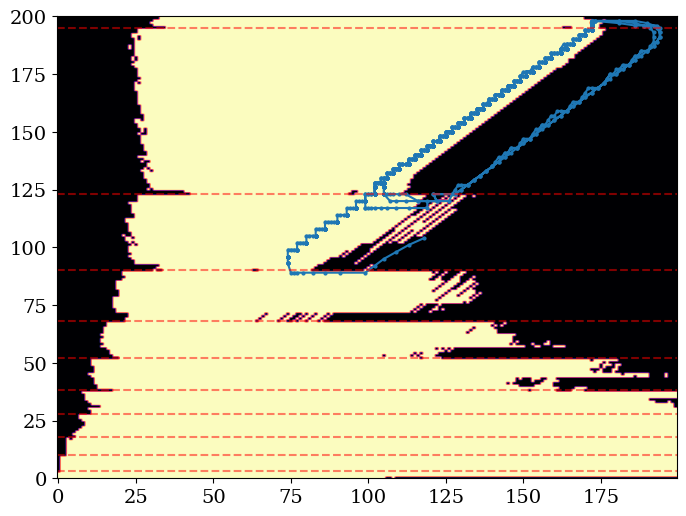

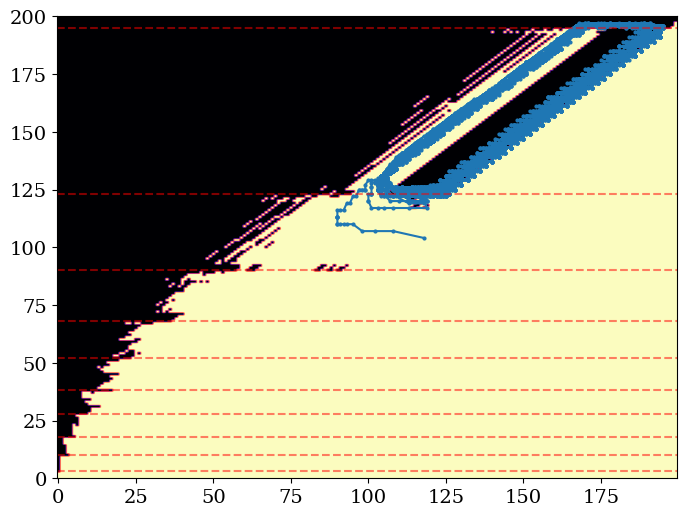

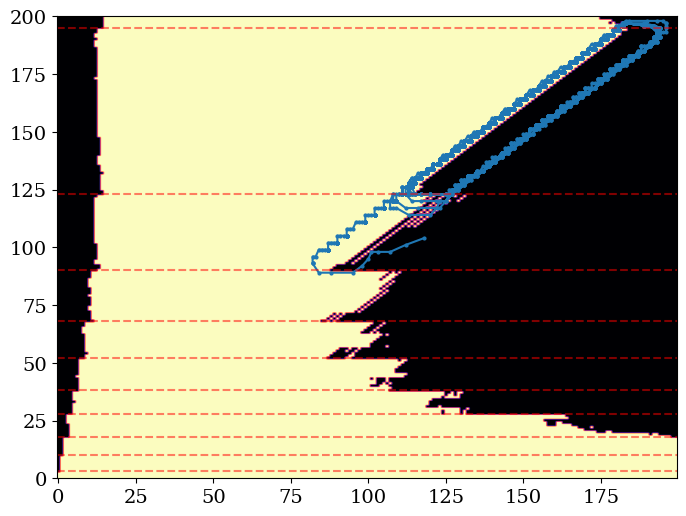

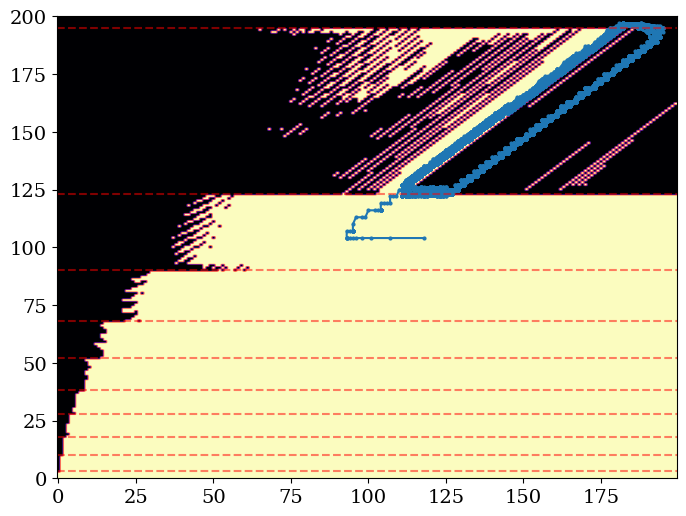

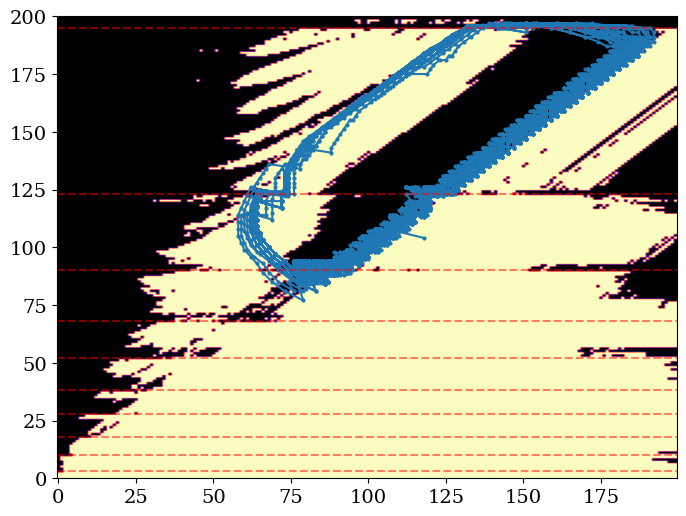

In [214]:
threshold = 13
d = "cpt/"

count = 0

files = os.listdir(d)

for idx,row in enumerate(cpt):
    amplitudes = row["amplitudes"]
    if np.mean(amplitudes) > threshold:
        count += 1
        direction = []
        with open(d+files[idx], "rb") as f:
            res = pickle.load(f)
        w = res["wealth"]
        h = res["health"]
    
        t = 5000
        plt.imshow(res["policy"].T, origin="lower", aspect="auto", cmap="magma")
        plt.plot(
            w[2,-t:],
            h[2,-t:],
            "-o",
            markersize=2
        )
        plt.ylim(0,200)
        for val in np.where(np.diff(health_cost[:,0])!=0)[0]:
            plt.axhline(val+1, c="red", alpha=0.5, linestyle="dashed")
        plt.show()

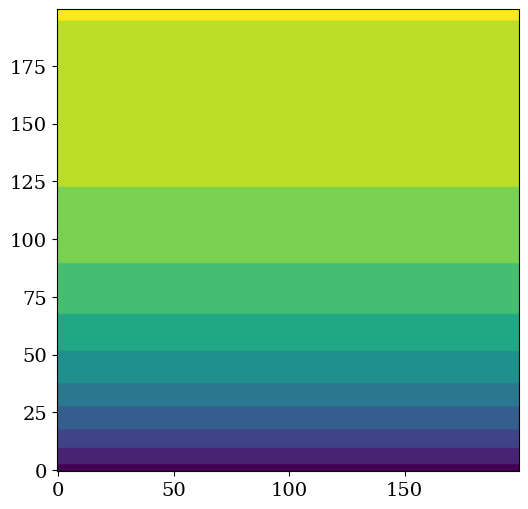

In [187]:
health_cost = np.zeros((200,200))
for i in range(200):
    health_cost[i] = compute_health_cost(i+1)

plt.imshow(health_cost, origin="lower")
plt.show()

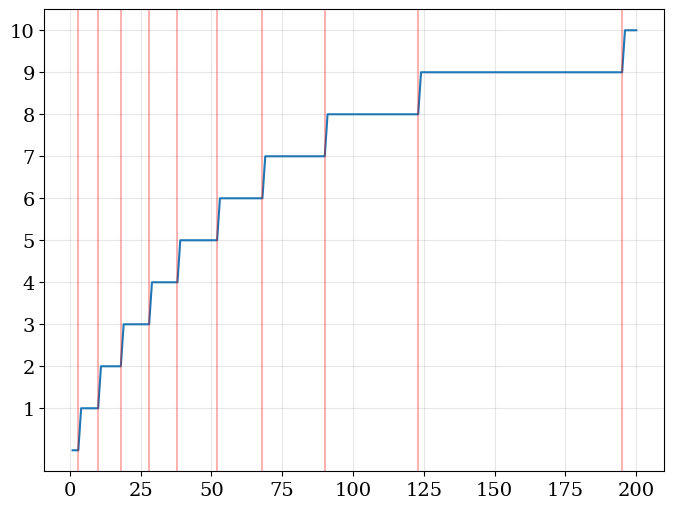

In [237]:
h_vals = np.linspace(1,200,200)
plt.plot(
    h_vals,
    compute_health_cost(h_vals)
)

plt.yticks(np.arange(1,11), np.arange(1,11))

for val in np.where(np.diff(health_cost[:,0])!=0)[0]+1 : 
    plt.axvline(val, c="red", alpha=0.3)

plt.grid()
plt.show()

In [238]:
np.where(np.diff(health_cost[:,0])!=0)[0]+1

array([  3,  10,  18,  28,  38,  52,  68,  90, 123, 195])

In [382]:
threshold = 13
d = "cpt/"

count = 0

files = os.listdir(d)

for idx,row in enumerate(cpt):
    amplitudes = row["amplitudes"]
    if np.mean(amplitudes) > threshold:
        count += 1
        if count == 8:
            direction = []
            with open(d+files[idx], "rb") as f:
                res = pickle.load(f)
            w = res["wealth"]
            h = res["health"]
            break

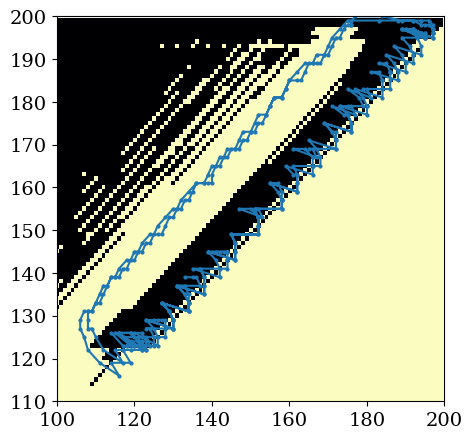

In [386]:
t = 400
plt.figure(figsize=(5,5))
plt.imshow(res["policy"].T, origin="lower", aspect="auto", cmap="magma")
plt.plot(
    res["wealth"][2,-t:],
    res["health"][2,-t:],
    "-o",
    markersize=2
)
plt.xlim(100,200)
plt.ylim(110,200)
plt.show()

In [387]:
A = res["params"]["w_delta_scale"]
alpha = res["params"]["alpha"]
N = 200

wealth_change = np.zeros((N,N))

for i in range(N):
    w = i+1
    for j in range(N):
        h = j+1
        cost = compute_health_cost(h)
        if res["policy"][w-1][h-1]:
            wealth_change[i][j] = compute_new_wealth(w-cost, A, (w-cost)**alpha*h**(1-alpha), N) - w
        else:
            wealth_change[i][j] = compute_new_wealth(w, A, w**alpha*h**(1-alpha), N) - w

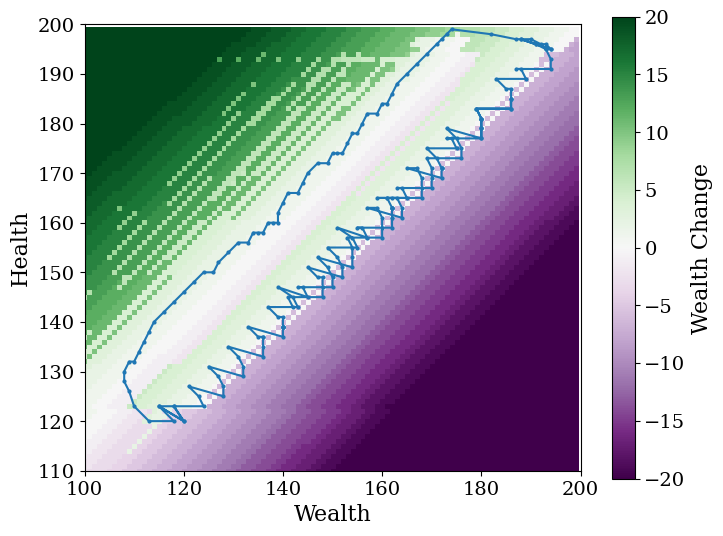

In [389]:
norm = TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20)

plt.imshow(wealth_change.T, origin="lower", cmap="PRGn", norm=norm)
plt.colorbar(label="Wealth Change")
plt.xlabel("Wealth")
plt.ylabel("Health")

plt.plot(
    res["wealth"][2,1000:1200],
    res["health"][2,1000:1200],
    "-o",
    markersize=2
)
plt.xlim(100,200)
plt.ylim(110,200)
plt.show()

# How do values of CPT parameters impact cycle size and location?

In [56]:
with open("cpt_dominant_frequencies_amplitudes.pickle", 'rb') as f:
    cpt = pickle.load(f)

0it [00:00, ?it/s]

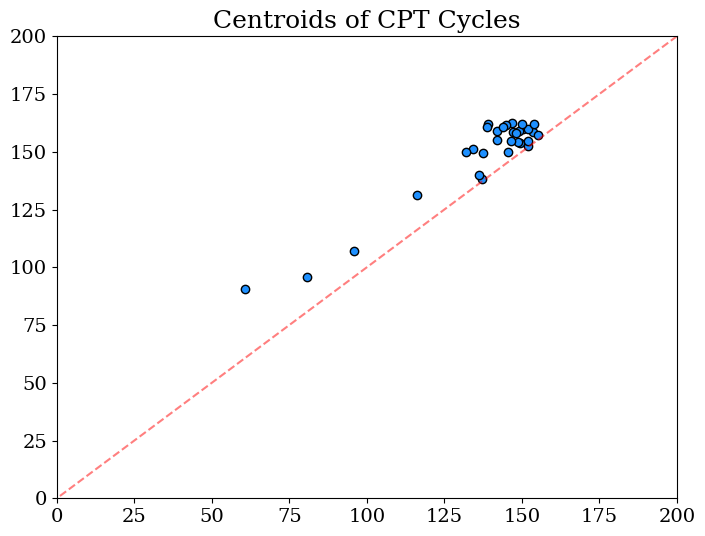

In [57]:
threshold = 13
d = "cpt/"
files = os.listdir(d)

P = []
centroids = []
utils = []
size = []

for idx,row in tqdm(enumerate(cpt)):
    amplitudes = row["amplitudes"]
    if np.mean(amplitudes) >= threshold:
        with open(d+files[idx], "rb") as f:
            res = pickle.load(f)
        p = res["params"]
        w = res["wealth"]
        h = res["health"]

        w_ = np.mean(w[:,-1])
        h_ = np.mean(h[:,-1])
        centroids.append(
            (w_, h_)
        )
        P.append(
            (p["alpha"], p["gamma"], p["omega"], p["eta"], p["w_delta_scale"], p["P_H_increase"], p["P_H_decrease"])
        )
        utils.append(
            utility(w_, h_, p["alpha"])
        )
        size.append(np.mean(amplitudes))

plt.scatter(
    [c[0] for c in centroids],
    [c[1] for c in centroids],
    color="dodgerblue",
    edgecolor="k",
)
plt.title("Centroids of CPT Cycles")
plt.xlim(0,200)
plt.ylim(0,200)
plt.plot([1,200], [1,200], c="red", alpha=0.5, linestyle="dashed")
plt.show()

PearsonRResult(statistic=np.float64(-0.1444985587768987), pvalue=np.float64(0.43801135542663716))


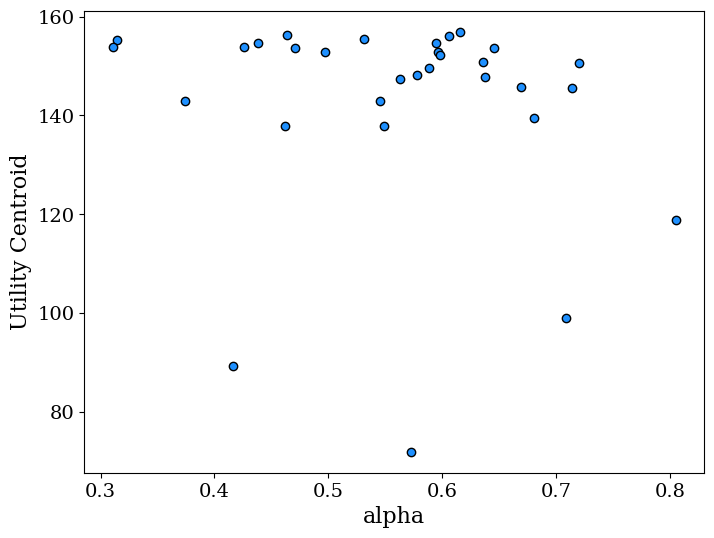

PearsonRResult(statistic=np.float64(-0.12951180225756598), pvalue=np.float64(0.48743658752113983))


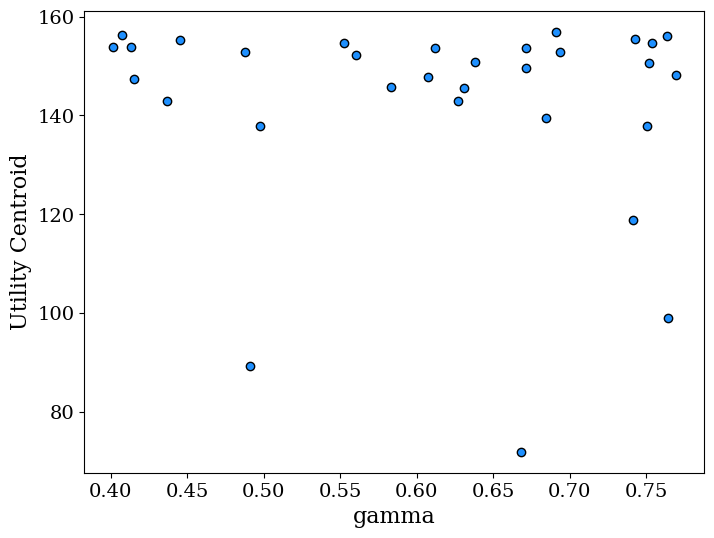

PearsonRResult(statistic=np.float64(0.11339918659914876), pvalue=np.float64(0.543586594825873))


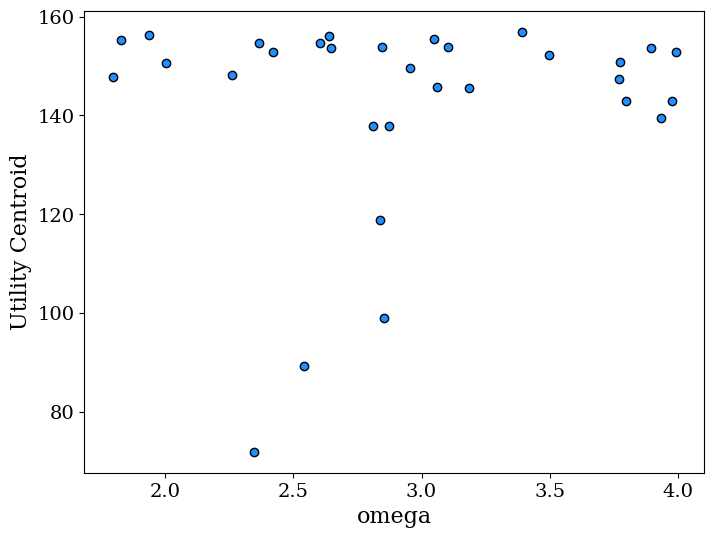

PearsonRResult(statistic=np.float64(0.24585440114928436), pvalue=np.float64(0.18247374649499545))


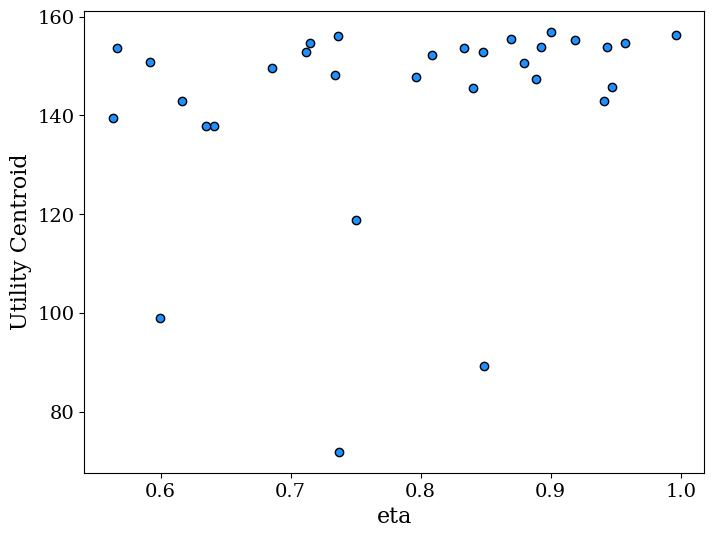

PearsonRResult(statistic=np.float64(0.1982720077763269), pvalue=np.float64(0.28496754707464217))


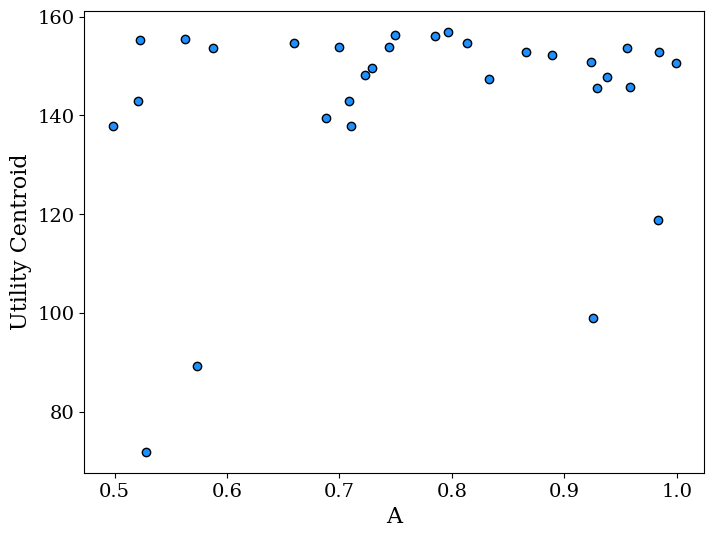

PearsonRResult(statistic=np.float64(0.15265750818755724), pvalue=np.float64(0.4122992315432083))


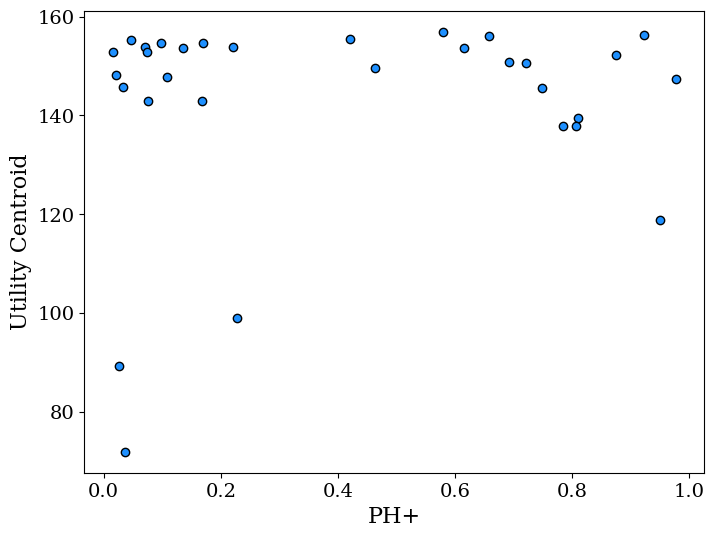

PearsonRResult(statistic=np.float64(0.06372520103539717), pvalue=np.float64(0.7334251961292306))


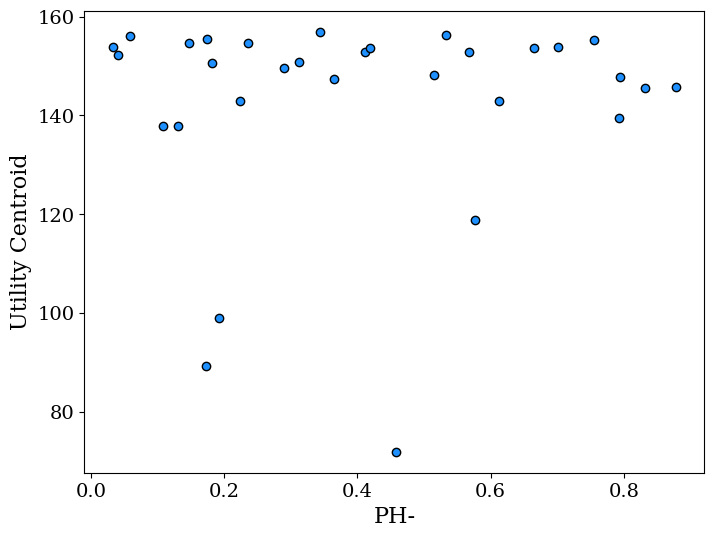

In [242]:
labels = ["alpha", "gamma", "omega", "eta", "A", "PH+", "PH-"]
for i in range(len(P[0])):
    print(pearsonr([p[i] for p in P], utils))
    plt.scatter([p[i] for p in P], utils, c="dodgerblue", edgecolor="k")
    plt.xlabel(labels[i])
    plt.ylabel("Utility Centroid")
    plt.show()

PearsonRResult(statistic=np.float64(0.08757972348561743), pvalue=np.float64(0.005039179945780751))


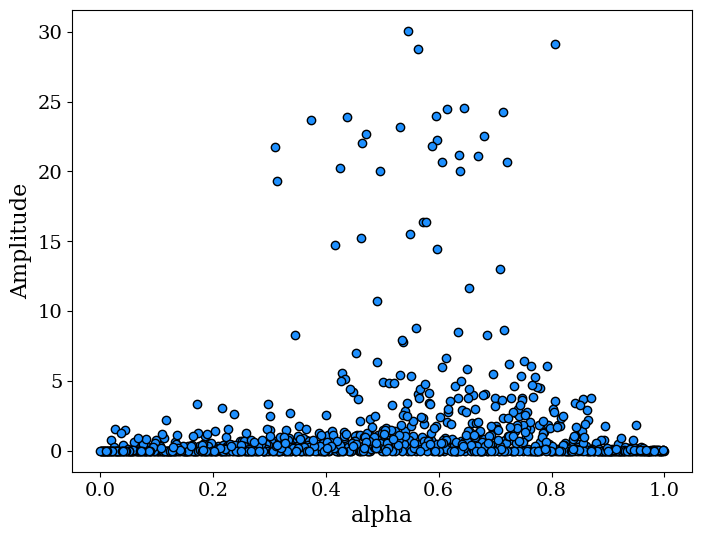

PearsonRResult(statistic=np.float64(-0.01800882107432128), pvalue=np.float64(0.5648686191273572))


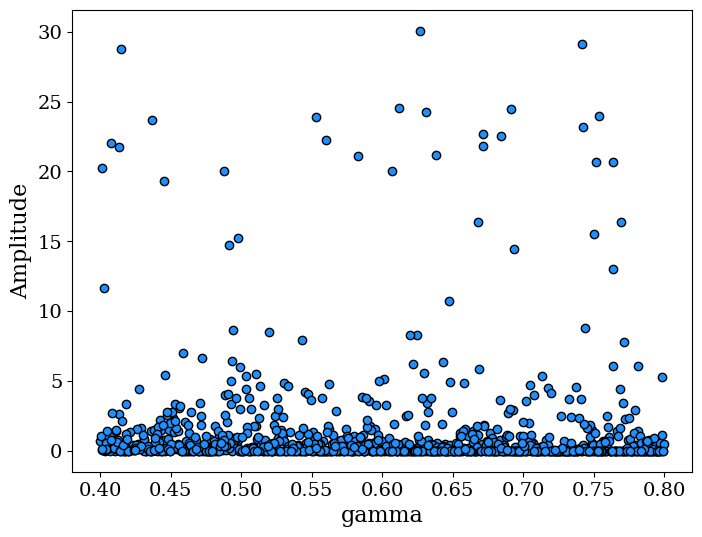

PearsonRResult(statistic=np.float64(0.08455122650555927), pvalue=np.float64(0.006785674193308173))


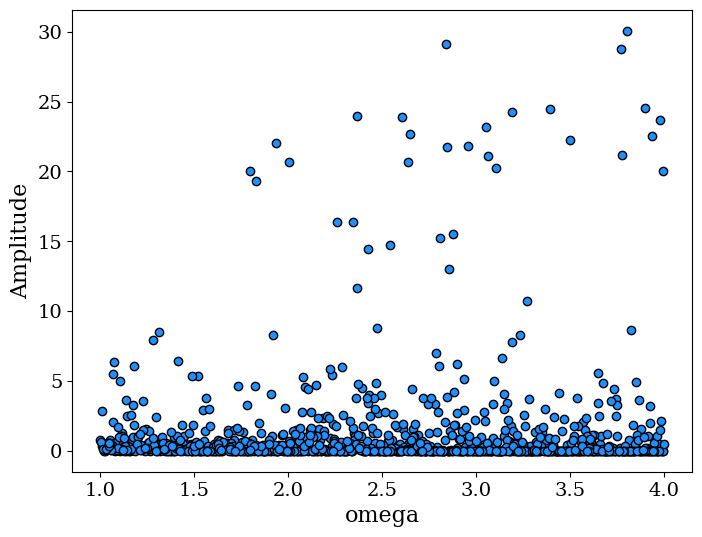

PearsonRResult(statistic=np.float64(0.021285670345023884), pvalue=np.float64(0.49625970597940355))


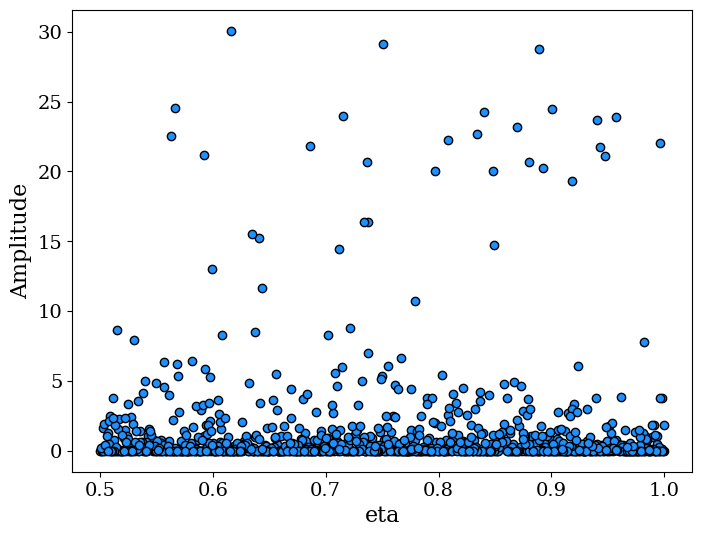

PearsonRResult(statistic=np.float64(0.1874973647441665), pvalue=np.float64(1.4822206403915877e-09))


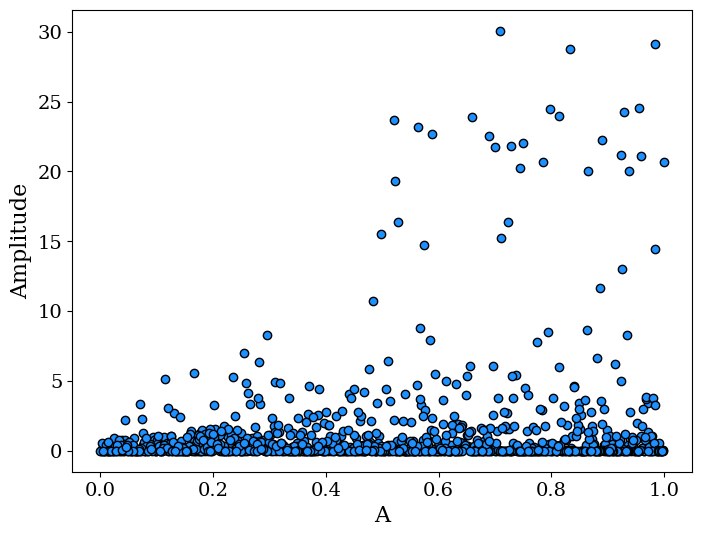

PearsonRResult(statistic=np.float64(-0.056420950524818686), pvalue=np.float64(0.07112118171375416))


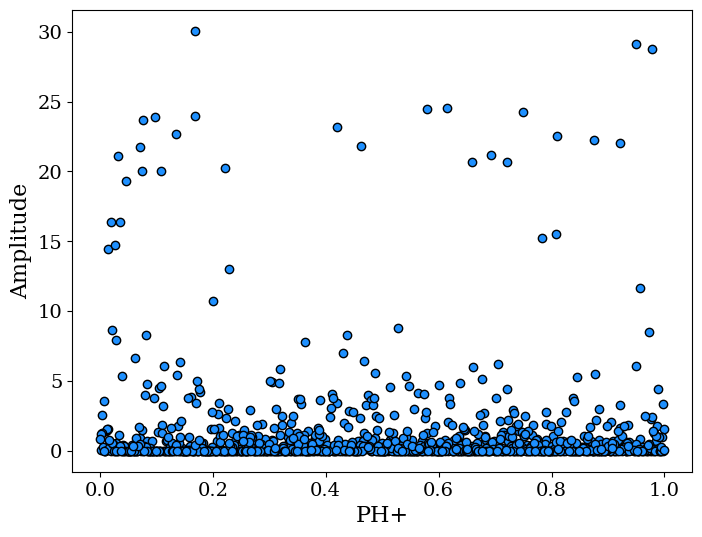

PearsonRResult(statistic=np.float64(-0.10231246971023093), pvalue=np.float64(0.0010432072038558489))


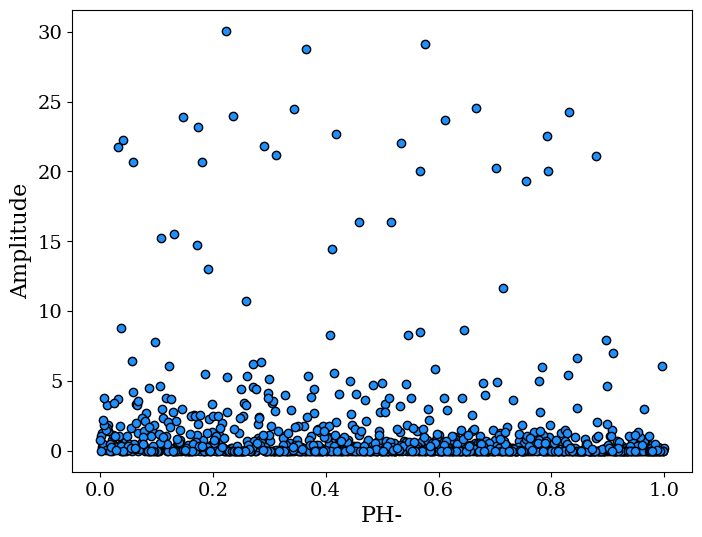

In [252]:
labels = ["alpha", "gamma", "omega", "eta", "A", "PH+", "PH-"]
for i in range(len(P[0])):
    print(pearsonr([p[i] for p in P], size))
    plt.scatter([p[i] for p in P], size, c="dodgerblue", edgecolor="k")
    plt.xlabel(labels[i])
    plt.ylabel("Amplitude")
    plt.show()

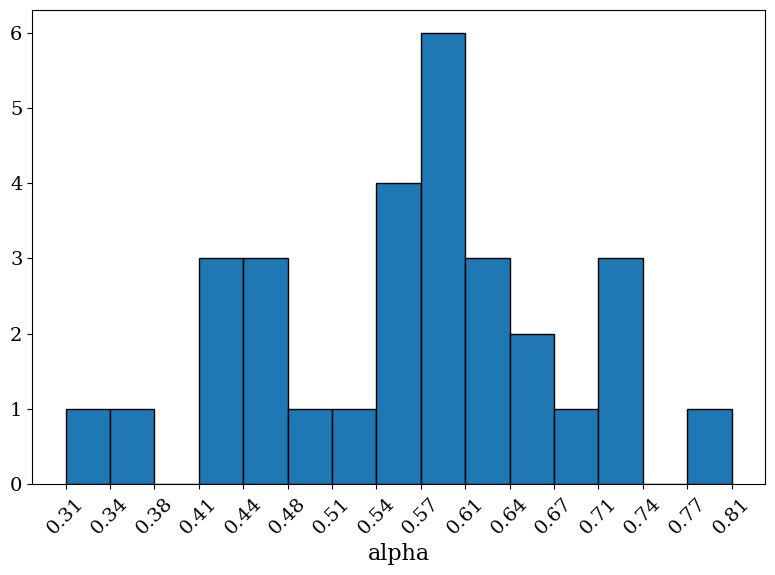

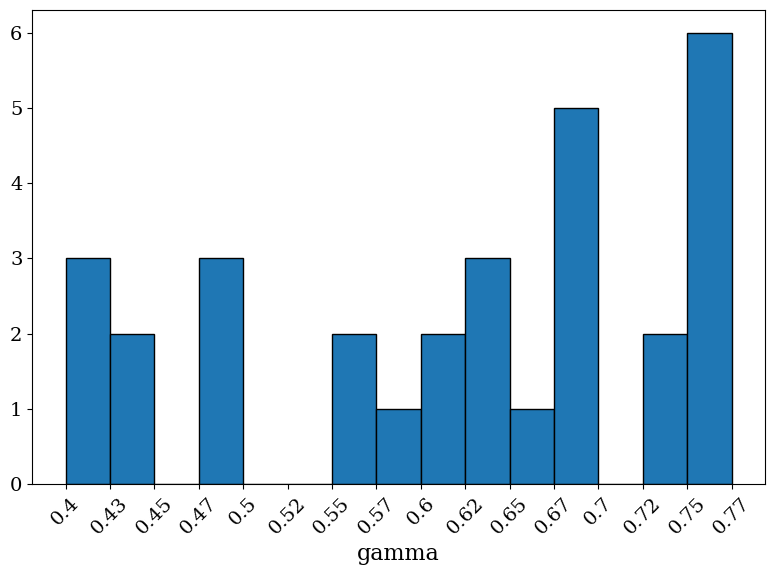

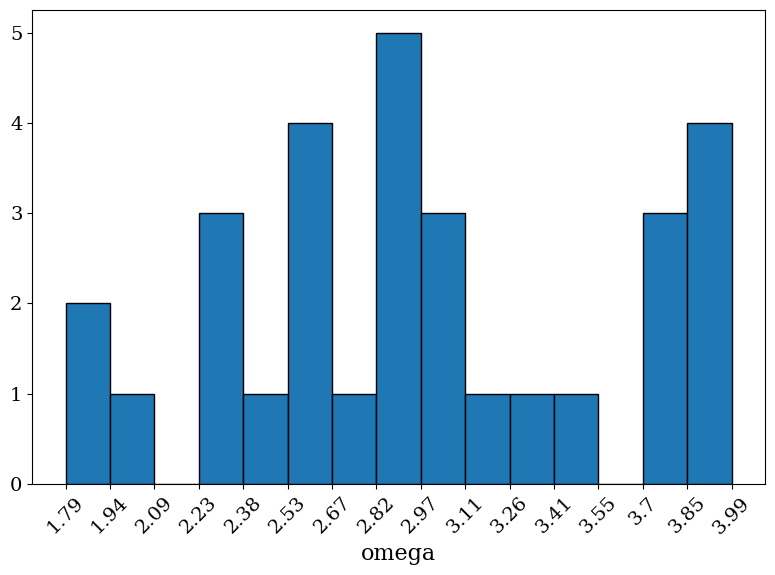

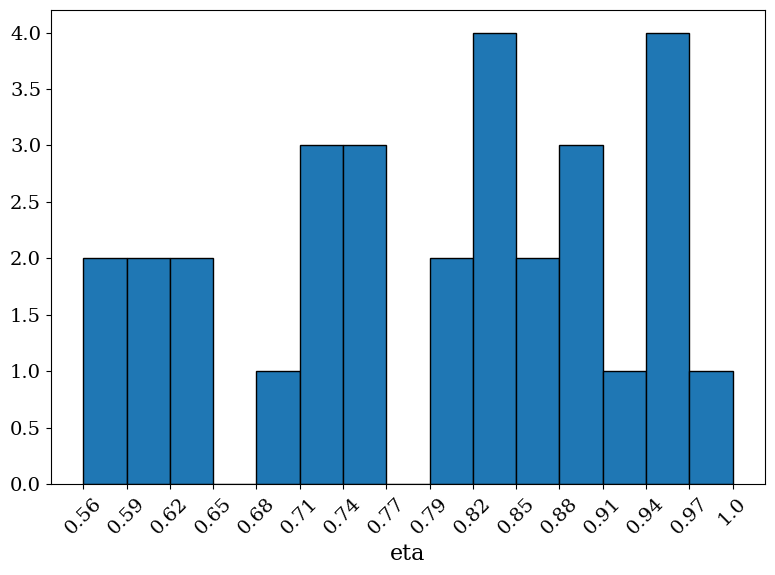

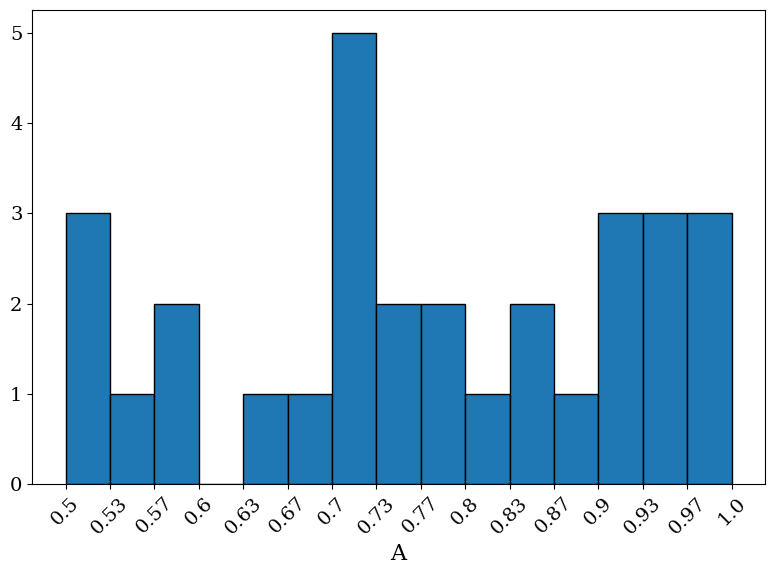

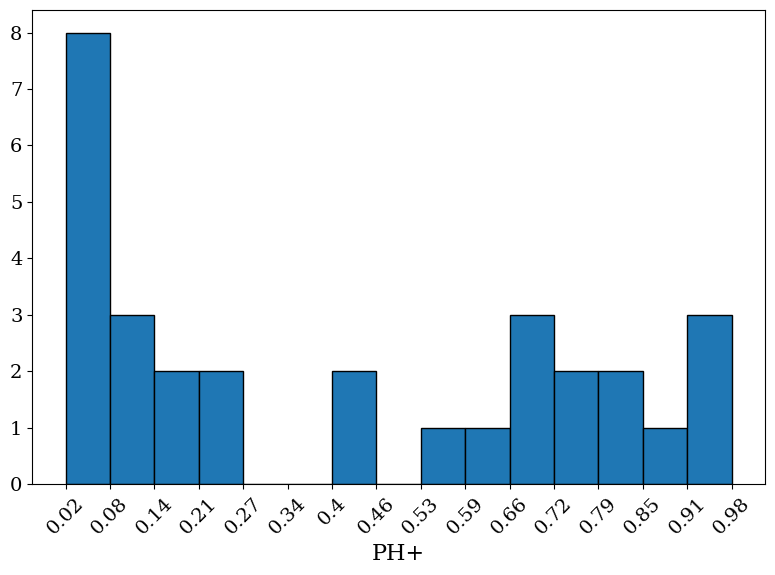

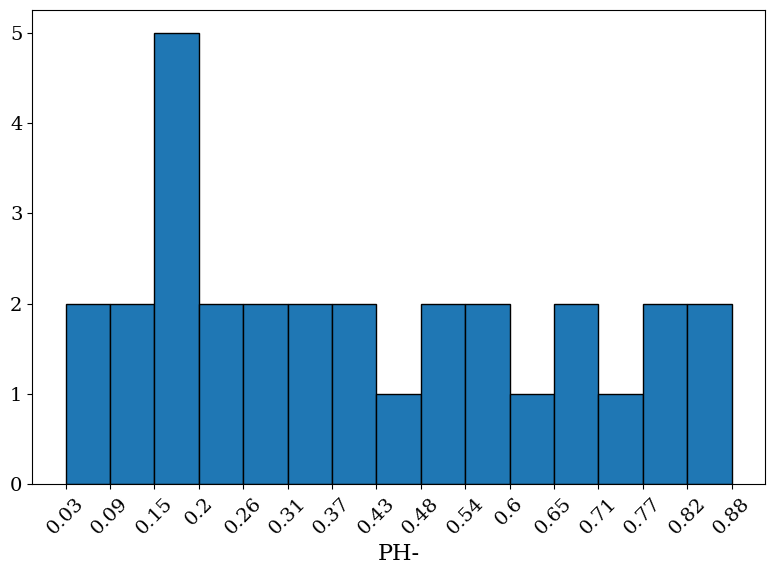

In [58]:
labels = ["alpha", "gamma", "omega", "eta", "A", "PH+", "PH-"]

for i in range(len(P[0])):
    values = [p[i] for p in P]
    mn, mx = min(values), max(values)

    n = 16
    edges = np.linspace(mn, mx, n)
    centers = 0.5 * (edges[:-1] + edges[1:])  # centers for bar positions

    high_amplitude_sims = np.zeros(n - 1)
    for k in range(1, n):
        for j, val in enumerate(values):
            if edges[k - 1] < val <= edges[k]:
                if size[j] >= 13:
                    high_amplitude_sims[k - 1] += 1

    plt.bar(
        centers,
        high_amplitude_sims,
        width=(edges[1] - edges[0]),
        align="center",
        edgecolor="k"
    )

    # ✅ show ticks at each bin edge
    plt.xticks(edges, np.round(edges, 2), rotation=45)

    plt.xlabel(labels[i])
    plt.tight_layout()
    plt.show()


In [75]:
with open("cpt/0.6808952922484166_0.7927779653756865_0.8095311349330477_0.6843807798651865_0.6885338748262912_3.9358726135546007_0.5630559108419687.pickle", "rb") as f:
    cpt_disc = pickle.load(f)

with open("cpt_continuous/0.6808952922484166_0.7927779653756865_0.8095311349330477_0.6843807798651865_0.6885338748262912_3.9358726135546007_0.5630559108419687.pickle", "rb") as f:
    cpt_cont = pickle.load(f)

with open("pt_continuous/0.6808952922484166_0.7927779653756865_0.8095311349330477_1_0.6885338748262912_1_1.pickle", "rb") as f:
    pt_cont = pickle.load(f)

with open("pt/0.6808952922484166_0.7927779653756865_0.8095311349330477_1_0.6885338748262912_1_1.pickle", "rb") as f:
    pt_disc = pickle.load(f)

with open("cpt_continuous_linear/0.6808952922484166_0.7927779653756865_0.8095311349330477_0.6843807798651865_0.6885338748262912_3.9358726135546007_0.5630559108419687.pickle", "rb") as f:
    cpt_cont_lin = pickle.load(f)

with open("pt_continuous_linear/0.6808952922484166_0.7927779653756865_0.8095311349330477_1_0.6885338748262912_1_1.pickle", "rb") as f:
    pt_cont_lin = pickle.load(f)

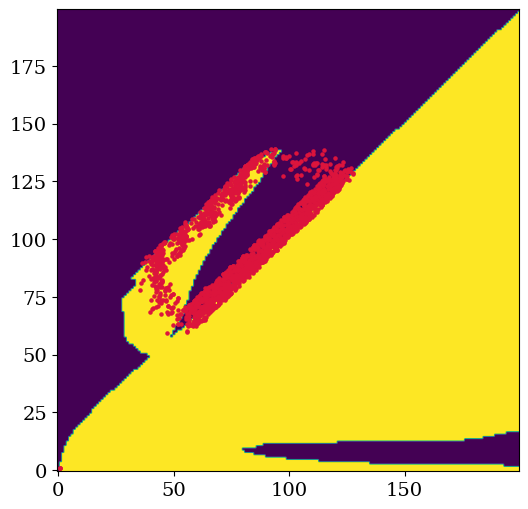

In [77]:
plt.imshow(cpt_cont["policy"].T, origin="lower")

plt.scatter(
    unpack_and_dequantize(cpt_cont["wealth"][:,-1], 200),
    unpack_and_dequantize(cpt_cont["health"][:,-1], 200),
    c = 'crimson',
    s=5
)

plt.show()

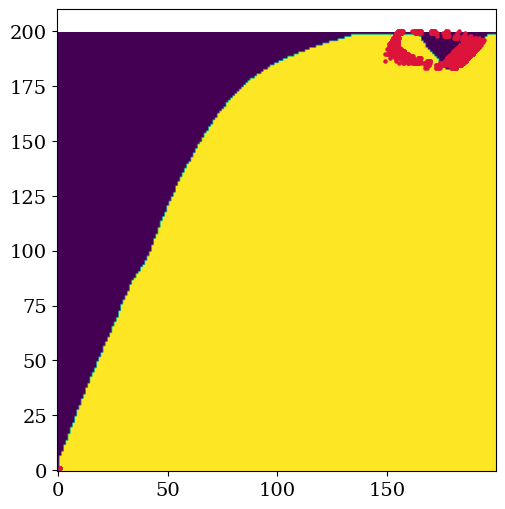

In [92]:
plt.imshow(pt_cont["policy"].T, origin="lower")

plt.scatter(
    unpack_and_dequantize(pt_cont["wealth"][:,-1], 200),
    unpack_and_dequantize(pt_cont["health"][:,-1], 200),
    c = 'crimson',
    s=5
)

plt.show()

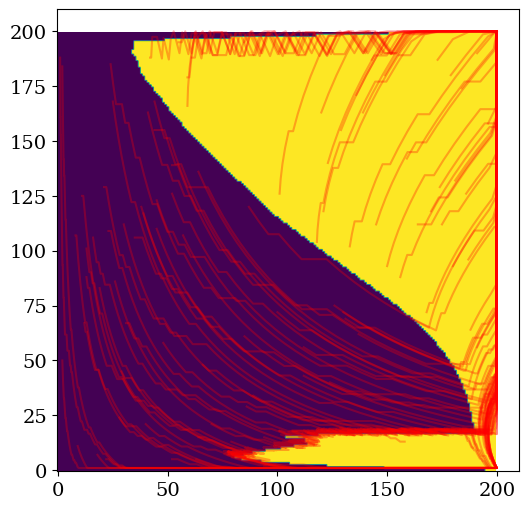

In [78]:
plt.imshow(cpt_cont_lin["policy"].T, origin="lower")

w = unpack_and_dequantize(cpt_cont_lin["wealth"], 200)
h = unpack_and_dequantize(cpt_cont_lin["health"], 200)

for i in range(100):
    plt.plot(w[i], h[i], c="r", alpha=0.3)


plt.show()

In [82]:
h[:,-1]

array([200.00002, 200.00002, 200.00002, ..., 200.00002, 200.00002,
       200.00002], dtype=float32)

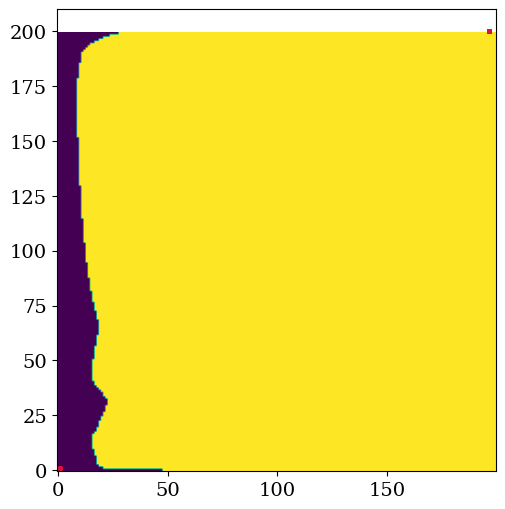

In [96]:
plt.imshow(pt_cont_lin["policy"].T, origin="lower")

plt.scatter(
    unpack_and_dequantize(pt_cont_lin["wealth"][:,-1], 200),
    unpack_and_dequantize(pt_cont_lin["health"][:,-1], 200),
    c = 'crimson',
    s=5
)

plt.show()

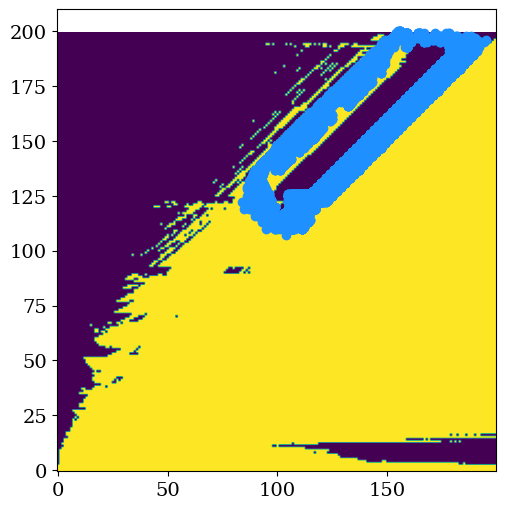

In [93]:
plt.imshow(cpt_disc["policy"].T, origin="lower")
plt.scatter(
    cpt_disc["wealth"][:,-1],
    cpt_disc["health"][:,-1],
    c="dodgerblue"
)
plt.show()

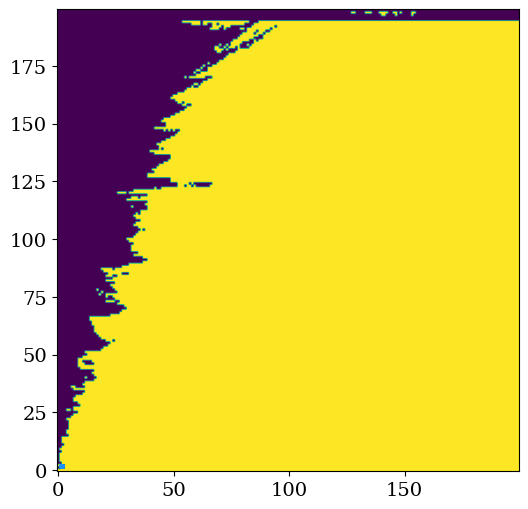

In [94]:
plt.imshow(pt_disc["policy"].T, origin="lower")

plt.scatter(
    unpack_and_dequantize(pt_disc["wealth"][:,-1], 200),
    unpack_and_dequantize(pt_disc["health"][:,-1], 200),
    c = 'dodgerblue',
    s=5
)

plt.show()